# AutoEncoder for CSC

###  Import and function definition

In [3]:
import pandas as pd
import numpy as np
import math, time, copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using:", device)

You are using: cuda


In [4]:
def Show2Dimg(img, title='CSC occupancy'):
    fig = plt.figure(figsize =(8, 8))
    img_temp = copy.deepcopy(img)
    cmap = plt.cm.jet
    cmap.set_under(color='white')
    max_=np.max(img_temp)
    img_temp[img_temp==0] = np.nan
    plt.imshow(img_temp, cmap=cmap, vmin=0.0000000001, vmax=max_)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.show()
    del img_temp

def PLots_in_training(X, Xreco):
    print(' >> original image:')
    img = X[0][0].cpu().numpy()
    Show2Dimg(img)
    print(' >> AE-reco image:')
    img_reco = Xreco[0][0].detach().cpu().numpy()
    Show2Dimg(img_reco)
    print(' >> loss map:')
    img_loss = F.mse_loss(Xreco[0], X[0], reduction='none')[0].detach().cpu().numpy()
    Show2Dimg(img_loss)

### Loading Data from previous strep

In [5]:
me = "hRHGlobalm3"
data = np.load(me+'_files.npz')
selected_chamber = data["imgs"]

In [14]:
# sanity check
selected_chamber.shape


(2953, 34, 50)

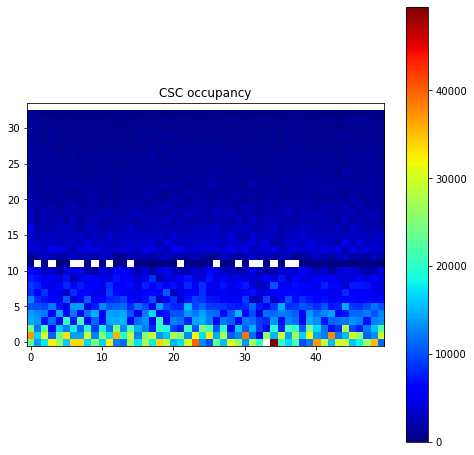

In [6]:
mean_matrix = np.mean(selected_chamber, axis=0)
dim = len(selected_chamber)
Show2Dimg(mean_matrix)
mean_matrix[mean_matrix == 0] = np.nan

In [17]:
selected_chamber.shape

(2953, 34, 50)

In [7]:
tensor_list = [(torch.tensor(m, dtype=torch.float32)).unsqueeze(0) for m in selected_chamber]
print(tensor_list[0].size())
training_dim = int(dim*0.85)
training_tensor = tensor_list[:training_dim]
validation_tensor = tensor_list[training_dim:]
print(f"Data ({len(selected_chamber)}) = Training sample ({len(training_tensor)}) + Validation sample ({len(validation_tensor)})")

torch.Size([1, 34, 50])
Data (2953) = Training sample (2510) + Validation sample (443)


In [35]:
#for k in range(len(validation_tensor)):
#    for i in range(50, 100):
#        for j in range(50, 100):
#            if (i<1.3*j-15 and i>0.7*j+15):
#                validation_tensor[k][0][i][j]=0

In [33]:
training_dataset = TensorDataset(*training_tensor)
validation_dataset = TensorDataset(*validation_tensor)

training_loader = DataLoader(dataset=training_tensor, 
                             batch_size=64, 
                             num_workers=10, 
                             shuffle=True)

validation_loader = DataLoader(dataset=validation_tensor, 
                               batch_size=32,
                               num_workers=10, 
                               shuffle=False)

### Define ResNet Model

In [34]:
class ResBlock(nn.Module):
    '''
    For encoding, define the nominal resnet block
    '''
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        self.downsample = out_channels//in_channels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=self.downsample, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=self.downsample)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)

        if self.downsample > 1:
            residual = self.shortcut(x)

        out += residual
        out = self.relu(out)

        return out

class ResBlockTranspose(nn.Module):
    '''
    For decoding, define the transposed resnet block, aka "de-convolution"
    '''
    def __init__(self, in_channels, out_channels, out_shape=None):
        super(ResBlockTranspose, self).__init__()
        self.upsample = in_channels//out_channels  
        self.convT1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=self.upsample, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.convT2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, padding=1)

        self.shortcutT = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=1, stride=self.upsample)
        self.out_shape = out_shape

    def forward(self, x):
        residual = x
        
        if self.out_shape is None:
            out = self.convT1(x)
        else:
            out = self.convT1(x, output_size=(x.size()[0], x.size()[1], self.out_shape[0], self.out_shape[1]))
        out = self.relu(out)
        out = self.convT2(out)

        if self.upsample > 1:
            if self.out_shape is None:
                residual = self.shortcutT(x)
            else:
                residual = self.shortcutT(x, output_size=(x.size()[0], x.size()[1], self.out_shape[0], self.out_shape[1]))
            
        out += residual
        out = self.relu(out)

        return out

In [35]:
class ResNetAE(nn.Module):
    '''
    Define the full ResNet autoencoder model
    '''
    def __init__(self, in_channels, nblocks, fmaps):
        super(ResNetAE, self).__init__()

        self.fmaps = fmaps
        self.nblocks = nblocks
        self.in_channels = in_channels
        
        # Initialize encoding layers
        self.econv0 = nn.Sequential(nn.Conv2d(in_channels, fmaps[0], kernel_size=3, stride=1, padding=1), nn.ReLU())
        self.elayer1 = self.block_layers(self.nblocks, [fmaps[0],fmaps[0]], 'enc')
        self.elayer2 = self.block_layers(1, [fmaps[0],fmaps[1]], 'enc')
        self.elayer3 = self.block_layers(self.nblocks, [fmaps[1],fmaps[1]], 'enc')
        self.elayer4 = self.block_layers(1, [fmaps[1],fmaps[2]], 'enc')
        self.elayer5 = self.block_layers(self.nblocks, [fmaps[2],fmaps[2]], 'enc')
        
        # Initialize decoding layers
        self.fc = nn.Linear(self.fmaps[-1], self.fmaps[-1]*5*7) # 5x5
        self.dlayer5 = self.block_layers(self.nblocks, [fmaps[2],fmaps[2]], 'dec', out_shape=None)
        self.dlayer4 = self.block_layers(1, [fmaps[2],fmaps[1]], 'dec', out_shape=(9,13))
        self.dlayer3 = self.block_layers(self.nblocks, [fmaps[1],fmaps[1]], 'dec', out_shape=None)
        self.dlayer2 = self.block_layers(1, [fmaps[1],fmaps[0]], 'dec', out_shape=(17,25))
        self.dlayer1 = self.block_layers(self.nblocks, [fmaps[0],fmaps[0]], 'dec', out_shape=None)
        self.dconv0 = nn.ConvTranspose2d(fmaps[0], in_channels, kernel_size=3, stride=1, padding=(1,1))
        self.dconv0_relu = nn.ReLU(inplace=True)
        
        self.debug = False
        #self.debug = True

    def block_layers(self, nblocks, fmaps, state, out_shape=None):
        '''
        Convenience function: append several resnet blocks in sequence
        '''
        layers = []
        for _ in range(nblocks):
            if state == 'enc':
                layers.append(ResBlock(fmaps[0], fmaps[1]))
            else:
                layers.append(ResBlockTranspose(fmaps[0], fmaps[1], out_shape)) 
        return nn.Sequential(*layers)


    def forward(self, x):
        
        # Encoding
        if self.debug: print(x.size())
        if self.debug: print("Encode")
        x = self.econv0(x)
        if self.debug: print(x.size())
        x = F.max_pool2d(x, kernel_size=2)
        if self.debug: print(x.size())

        x = self.elayer1(x)
        if self.debug: print(x.size())
        x = self.elayer2(x)
        if self.debug: print(x.size())
        x = self.elayer3(x)
        if self.debug: print(x.size()) #32x9x18
        x = self.elayer4(x)
        if self.debug: print(x.size())
        x = self.elayer5(x)
        if self.debug: print(x.size())
        
        # Bottleneck comes from GlobalMaxPool
        if self.debug: print("Maxpool-FC")
        x = F.max_pool2d(x, kernel_size=x.size()[2:])
        if self.debug: print(x.size())
        x = x.view(x.size()[0], -1)
        if self.debug: print(x.size())
        
        # Expand bottleneck
        # Dimensions follow encoding steps in reverse, as much as possible
        x = self.fc(x) # expand   
        if self.debug: print(x.size())
        #x = x.view(-1, self.fmaps[1], 4, 9) 
        #x = x.view(-1, self.fmaps[1], 9, 18) 
        x = x.view(-1, self.fmaps[-1], 5, 7) 
        if self.debug: print(x.size())        
        
        # Decoding
        if self.debug: print("Decode")
        x = self.dlayer5(x)
        if self.debug: print(x.size())
        x = self.dlayer4(x)
        if self.debug: print(x.size())
        x = self.dlayer3(x)
        if self.debug: print(x.size())
        x = self.dlayer2(x)
        if self.debug: print(x.size())
        x = self.dlayer1(x)
        if self.debug: print(x.size())
        
        x = F.interpolate(x, scale_factor=2)
        if self.debug: print(x.size())
        x = self.dconv0(x, output_size=(x.size()[0], self.in_channels, 34, 50))
        if self.debug: print(x.size())
        x = self.dconv0_relu(x)
            
        return x
        #return x, mu, logvar

### Training Loop

In [36]:
ae = ResNetAE(1, 3, [16, 32, 64]).to(device)
optimizer = optim.Adam(ae.parameters(), lr=5.e-4)
train_loss, val_loss =[], []
epochs = 100
for e in range(epochs):
    epoch = e+1
    print(f'***** Training Epoch {epoch} *****')
    # Run training
    ae.train()
    now = time.time()
    tloss=[]
    for i, figure in enumerate(training_loader):
        X = figure.to(device)
        #X = X
        optimizer.zero_grad()
        Xreco = ae(X)
        
        #if i==1:
        #    PLots_in_training(X, Xreco)
        #print(X)
        #loss = F.l1_loss(Xreco, X)
        #loss = F.mse_loss(Xreco, X) smooth_l1_loss
        loss = F.l1_loss(Xreco, X)
        tloss.append(loss.item())
        loss.backward()
        optimizer.step()
        if i%4 ==0:
            print(f'>> [{i}/{len(training_loader)}] Train loss:{loss.item()}')
    train_loss.append(np.mean(tloss))
    now = time.time() - now
    s = '>> Training time: %.2f min in %d steps'%( now/60, len(training_loader))
    print(s)

***** Training Epoch 1 *****
>> [0/40] Train loss:4418.56201171875
>> [4/40] Train loss:3387.891357421875
>> [8/40] Train loss:2484.27685546875
>> [12/40] Train loss:1945.2100830078125
>> [16/40] Train loss:1719.58349609375
>> [20/40] Train loss:1743.6121826171875
>> [24/40] Train loss:1636.09814453125
>> [28/40] Train loss:1616.6796875
>> [32/40] Train loss:1607.6622314453125
>> [36/40] Train loss:1558.9796142578125
>> Training time: 0.03 min in 40 steps
***** Training Epoch 2 *****
>> [0/40] Train loss:1551.094970703125
>> [4/40] Train loss:1485.4361572265625
>> [8/40] Train loss:1493.661376953125
>> [12/40] Train loss:1400.878662109375
>> [16/40] Train loss:1464.6617431640625
>> [20/40] Train loss:1446.2216796875
>> [24/40] Train loss:1385.26318359375
>> [28/40] Train loss:1346.0841064453125
>> [32/40] Train loss:1411.7615966796875
>> [36/40] Train loss:1341.6541748046875
>> Training time: 0.02 min in 40 steps
***** Training Epoch 3 *****
>> [0/40] Train loss:1363.7098388671875
>> [

>> [36/40] Train loss:929.6143798828125
>> Training time: 0.03 min in 40 steps
***** Training Epoch 19 *****
>> [0/40] Train loss:951.0730590820312
>> [4/40] Train loss:999.5748901367188
>> [8/40] Train loss:946.7957763671875
>> [12/40] Train loss:923.3322143554688
>> [16/40] Train loss:896.9442138671875
>> [20/40] Train loss:958.1654663085938
>> [24/40] Train loss:937.1949462890625
>> [28/40] Train loss:924.3802490234375
>> [32/40] Train loss:954.6283569335938
>> [36/40] Train loss:948.3529663085938
>> Training time: 0.03 min in 40 steps
***** Training Epoch 20 *****
>> [0/40] Train loss:915.5307006835938
>> [4/40] Train loss:926.130615234375
>> [8/40] Train loss:931.0782470703125
>> [12/40] Train loss:902.1907958984375
>> [16/40] Train loss:1014.1039428710938
>> [20/40] Train loss:916.2951049804688
>> [24/40] Train loss:950.9339599609375
>> [28/40] Train loss:924.5289306640625
>> [32/40] Train loss:887.3568115234375
>> [36/40] Train loss:948.8695068359375
>> Training time: 0.03 min i

>> [24/40] Train loss:969.166015625
>> [28/40] Train loss:921.5427856445312
>> [32/40] Train loss:961.4405517578125
>> [36/40] Train loss:910.425537109375
>> Training time: 0.03 min in 40 steps
***** Training Epoch 37 *****
>> [0/40] Train loss:928.5487670898438
>> [4/40] Train loss:933.8427124023438
>> [8/40] Train loss:893.3048706054688
>> [12/40] Train loss:927.5087890625
>> [16/40] Train loss:918.25439453125
>> [20/40] Train loss:933.533447265625
>> [24/40] Train loss:874.7720336914062
>> [28/40] Train loss:940.2940673828125
>> [32/40] Train loss:847.9324951171875
>> [36/40] Train loss:945.18994140625
>> Training time: 0.03 min in 40 steps
***** Training Epoch 38 *****
>> [0/40] Train loss:944.5487670898438
>> [4/40] Train loss:919.8375854492188
>> [8/40] Train loss:946.8605346679688
>> [12/40] Train loss:862.1192016601562
>> [16/40] Train loss:963.1912841796875
>> [20/40] Train loss:927.4430541992188
>> [24/40] Train loss:891.9269409179688
>> [28/40] Train loss:936.0648193359375
>

>> [24/40] Train loss:910.4495239257812
>> [28/40] Train loss:886.9959716796875
>> [32/40] Train loss:904.0281982421875
>> [36/40] Train loss:883.5034790039062
>> Training time: 0.03 min in 40 steps
***** Training Epoch 55 *****
>> [0/40] Train loss:906.306884765625
>> [4/40] Train loss:909.6775512695312
>> [8/40] Train loss:879.3370361328125
>> [12/40] Train loss:889.900634765625
>> [16/40] Train loss:897.72607421875
>> [20/40] Train loss:907.0902709960938
>> [24/40] Train loss:902.9430541992188
>> [28/40] Train loss:932.7677612304688
>> [32/40] Train loss:953.2896118164062
>> [36/40] Train loss:857.2317504882812
>> Training time: 0.03 min in 40 steps
***** Training Epoch 56 *****
>> [0/40] Train loss:974.5731811523438
>> [4/40] Train loss:900.955322265625
>> [8/40] Train loss:916.421875
>> [12/40] Train loss:907.7846069335938
>> [16/40] Train loss:913.4298095703125
>> [20/40] Train loss:904.1954345703125
>> [24/40] Train loss:918.8932495117188
>> [28/40] Train loss:935.6876831054688


>> [24/40] Train loss:846.6739501953125
>> [28/40] Train loss:899.4631958007812
>> [32/40] Train loss:916.8385009765625
>> [36/40] Train loss:883.8602294921875
>> Training time: 0.03 min in 40 steps
***** Training Epoch 73 *****
>> [0/40] Train loss:898.6326904296875
>> [4/40] Train loss:945.2271118164062
>> [8/40] Train loss:879.2880249023438
>> [12/40] Train loss:904.0919189453125
>> [16/40] Train loss:917.4197998046875
>> [20/40] Train loss:876.658203125
>> [24/40] Train loss:932.7838134765625
>> [28/40] Train loss:906.2697143554688
>> [32/40] Train loss:855.6510009765625
>> [36/40] Train loss:935.0205688476562
>> Training time: 0.02 min in 40 steps
***** Training Epoch 74 *****
>> [0/40] Train loss:879.1851196289062
>> [4/40] Train loss:879.9572143554688
>> [8/40] Train loss:898.89599609375
>> [12/40] Train loss:902.399658203125
>> [16/40] Train loss:934.9757080078125
>> [20/40] Train loss:922.091064453125
>> [24/40] Train loss:885.9379272460938
>> [28/40] Train loss:893.2767944335

>> [24/40] Train loss:920.3485107421875
>> [28/40] Train loss:863.6279296875
>> [32/40] Train loss:931.3271484375
>> [36/40] Train loss:892.9247436523438
>> Training time: 0.02 min in 40 steps
***** Training Epoch 91 *****
>> [0/40] Train loss:944.3833618164062
>> [4/40] Train loss:898.6744995117188
>> [8/40] Train loss:887.8199462890625
>> [12/40] Train loss:859.22021484375
>> [16/40] Train loss:941.199951171875
>> [20/40] Train loss:873.5932006835938
>> [24/40] Train loss:941.0443725585938
>> [28/40] Train loss:927.6318969726562
>> [32/40] Train loss:861.6536254882812
>> [36/40] Train loss:884.6534423828125
>> Training time: 0.02 min in 40 steps
***** Training Epoch 92 *****
>> [0/40] Train loss:977.1773681640625
>> [4/40] Train loss:886.3612670898438
>> [8/40] Train loss:902.9847412109375
>> [12/40] Train loss:954.7825927734375
>> [16/40] Train loss:881.2185668945312
>> [20/40] Train loss:853.45703125
>> [24/40] Train loss:895.5974731445312
>> [28/40] Train loss:838.3612670898438
>>

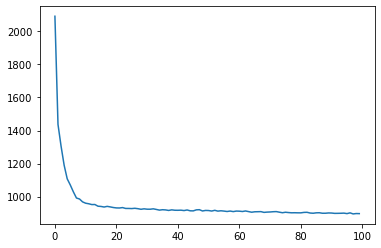

In [37]:
plt.plot(train_loss)

### Validation dataset

In [45]:
total_mean_l1_loss_list = []
for i, img in enumerate(validation_loader):
    img = img.to(device)
    #img = img*(img<10).float()
    reco_img = ae(img)
    
    print(f"***** batch {i} *****")
    #k=0
    #if True:
    batch = 1 # max 32
    for k in range(batch):
        # print(f" >> Example {k}")
        # print(' >> Original image:')
        img[k][0] = img[k][0] / np.max(img[k][0].cpu().numpy())
        # Show2Dimg(img[k][0].cpu().numpy())
        # print(' >> AE-reco image:')
        # Show2Dimg(reco_img[k][0].detach().cpu().numpy())
        # print(' >> Normalized loss map:')
        reco_img[k] = reco_img[k] / np.max(reco_img[k].cpu().detach().numpy())
        img_loss = F.l1_loss(reco_img[k], img[k], reduction='none')[0].detach().cpu().numpy()
        
        #Show2Dimg(img_loss/mean_matrix)
        # print('out', out)
        # change the nan number to 0
        # out = np.nan_to_num(out, nan=0.0)
        total_mean_l1_loss_list.append(np.sum(img_loss))
        # fig = plt.figure(figsize =(8, 8))
        # plt.imshow(out, cmap=plt.cm.jet, vmin=0, vmax=2)
        # plt.gca().invert_yaxis()
        # plt.colorbar()
        # plt.show()

***** batch 0 *****
***** batch 1 *****
***** batch 2 *****
***** batch 3 *****
***** batch 4 *****
***** batch 5 *****
***** batch 6 *****
***** batch 7 *****
***** batch 8 *****
***** batch 9 *****
***** batch 10 *****
***** batch 11 *****
***** batch 12 *****
***** batch 13 *****


Text(0, 0.5, 'count')

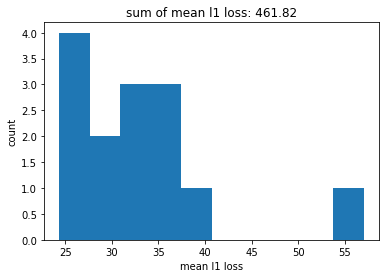

In [49]:
plt.hist(total_mean_l1_loss_list)
# add text for the sum
plt.title(f'sum of mean l1 loss: {np.round(float(np.sum(total_mean_l1_loss_list)), 2)}')
plt.xlabel('mean l1 loss')
plt.ylabel('count')

In [47]:
np.sum(total_mean_l1_loss_list)

461.82147

***** batch 0 *****
 >> Example 0
 >> Original image:


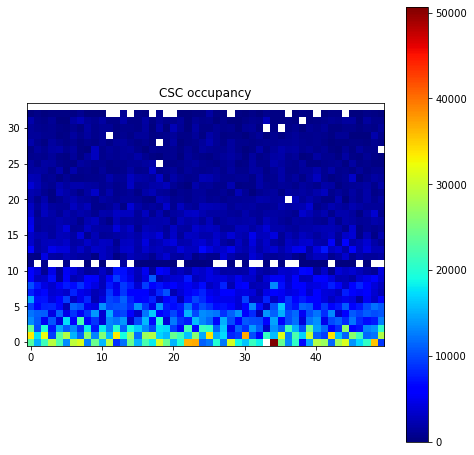

 >> AE-reco image:


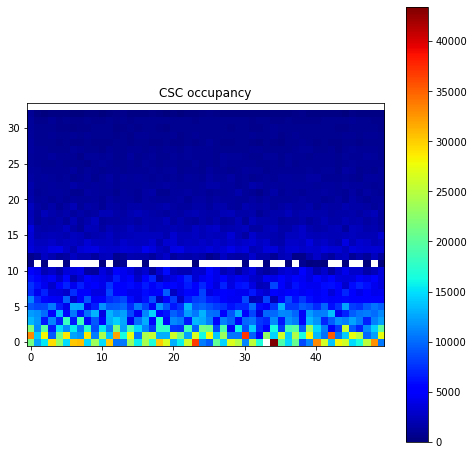

 >> Normalized loss map:


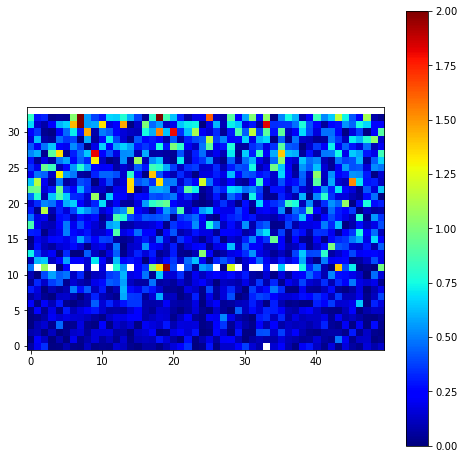

 >> Example 1
 >> Original image:


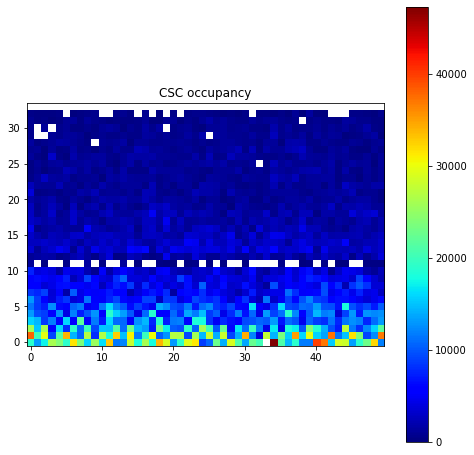

 >> AE-reco image:


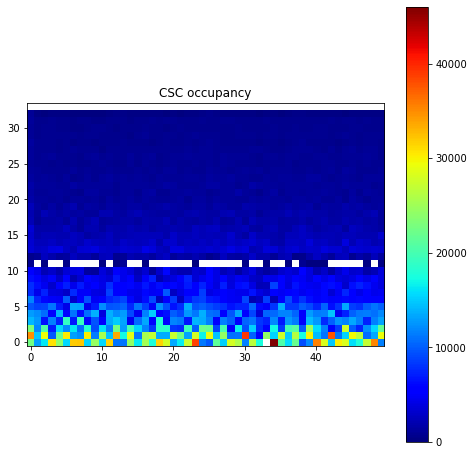

 >> Normalized loss map:


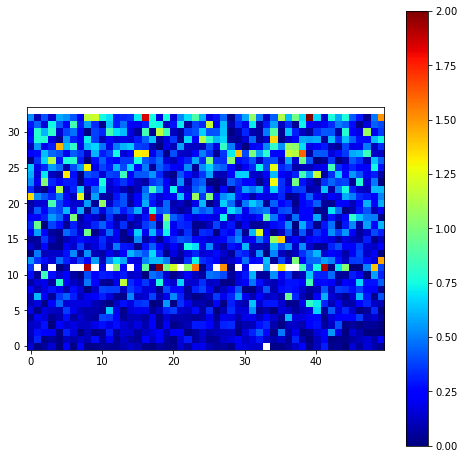

 >> Example 2
 >> Original image:


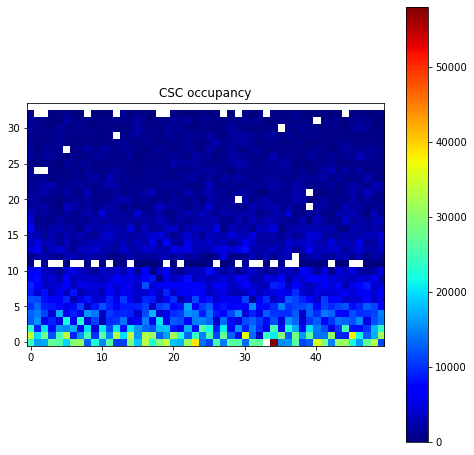

 >> AE-reco image:


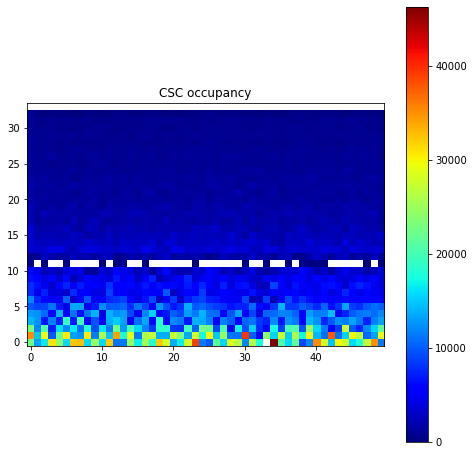

 >> Normalized loss map:


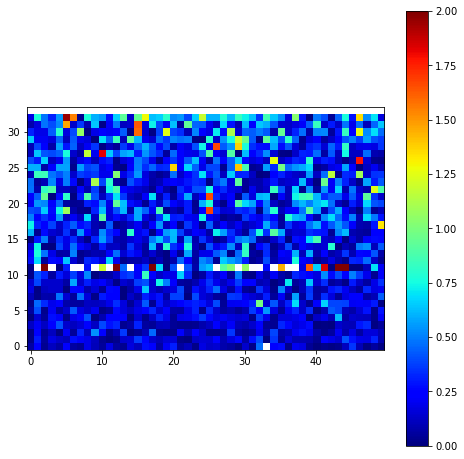

 >> Example 3
 >> Original image:


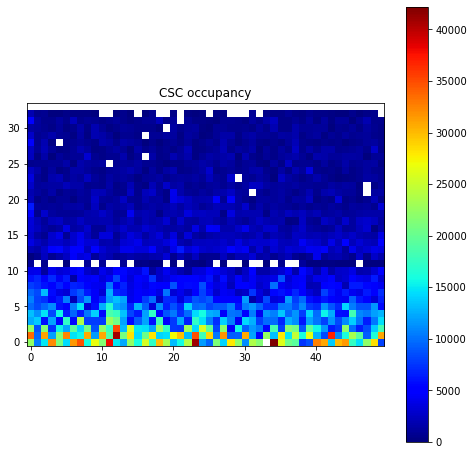

 >> AE-reco image:


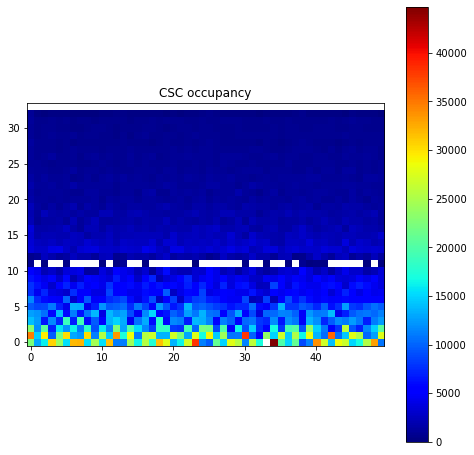

 >> Normalized loss map:


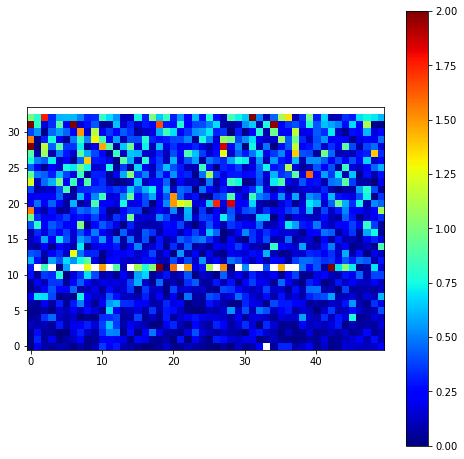

***** batch 1 *****
 >> Example 0
 >> Original image:


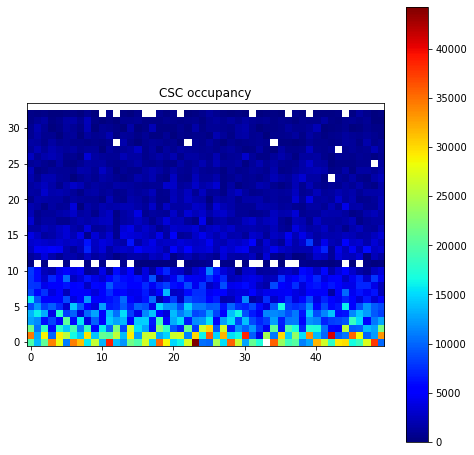

 >> AE-reco image:


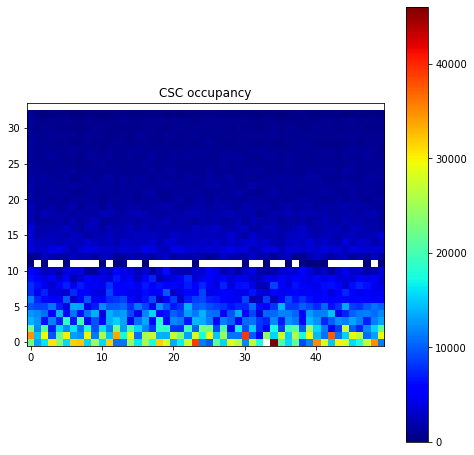

 >> Normalized loss map:


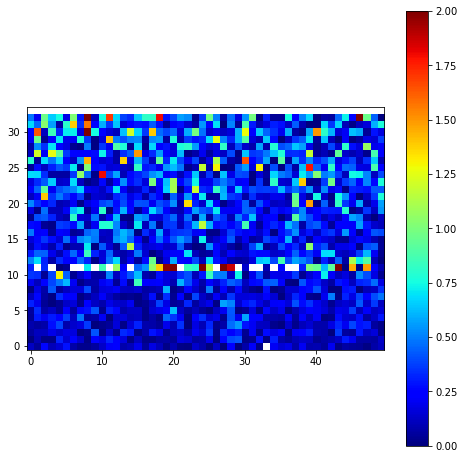

 >> Example 1
 >> Original image:


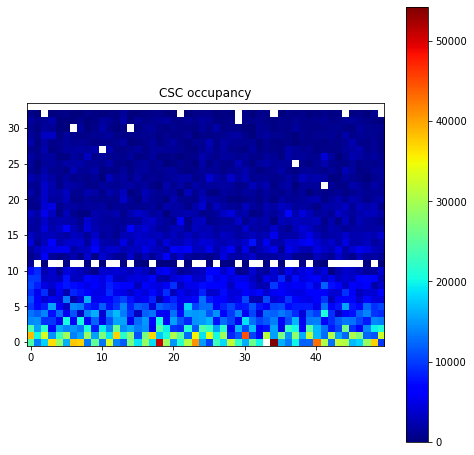

 >> AE-reco image:


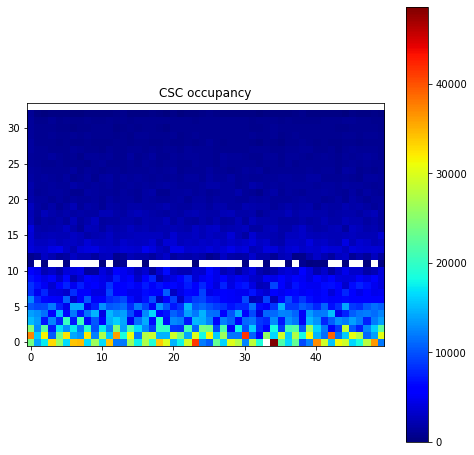

 >> Normalized loss map:


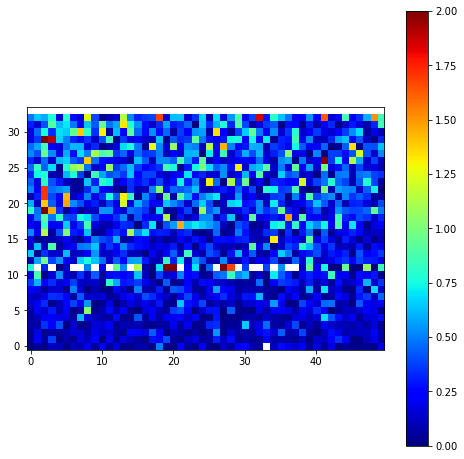

 >> Example 2
 >> Original image:


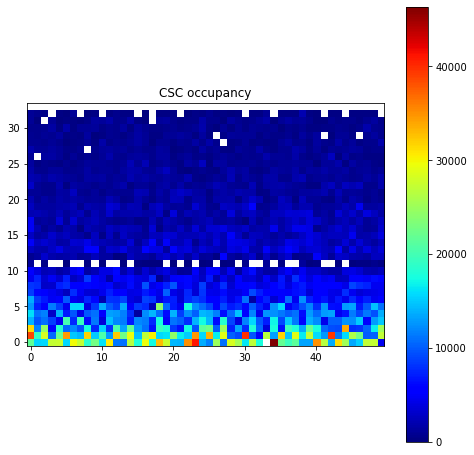

 >> AE-reco image:


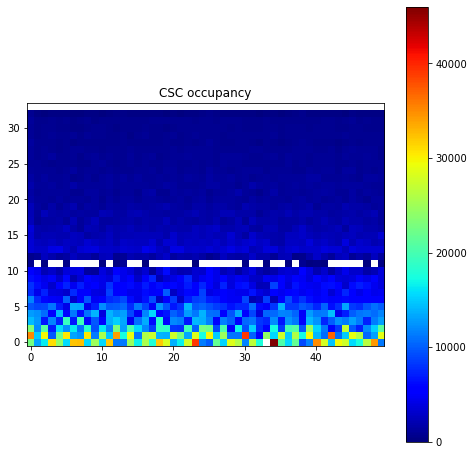

 >> Normalized loss map:


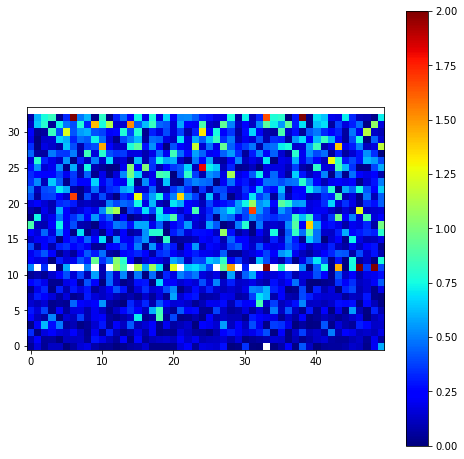

 >> Example 3
 >> Original image:


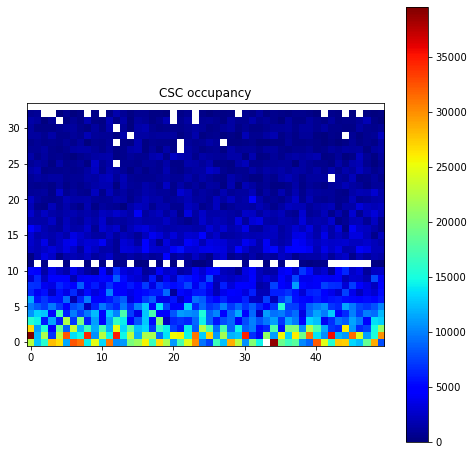

 >> AE-reco image:


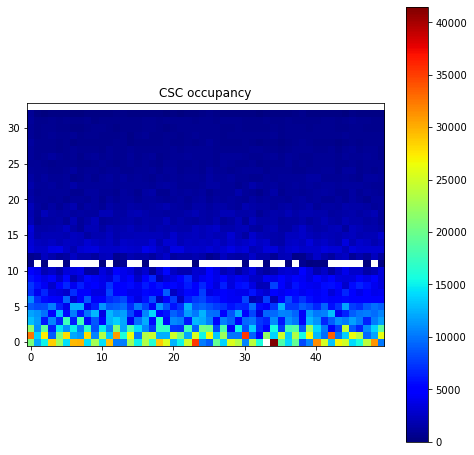

 >> Normalized loss map:


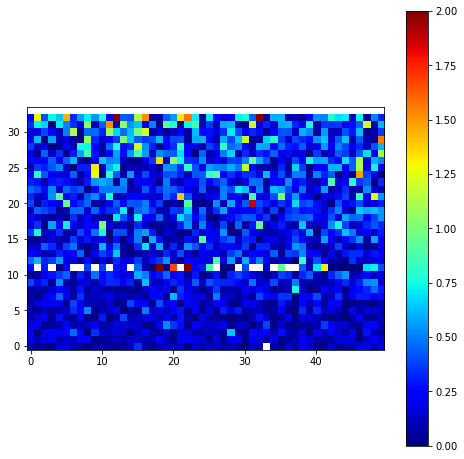

***** batch 2 *****
 >> Example 0
 >> Original image:


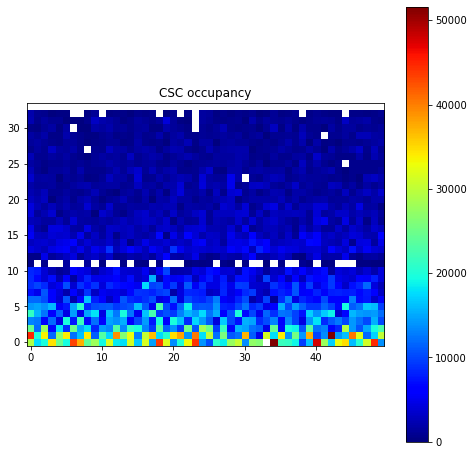

 >> AE-reco image:


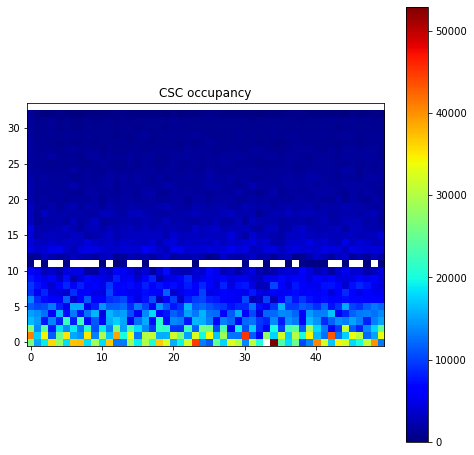

 >> Normalized loss map:


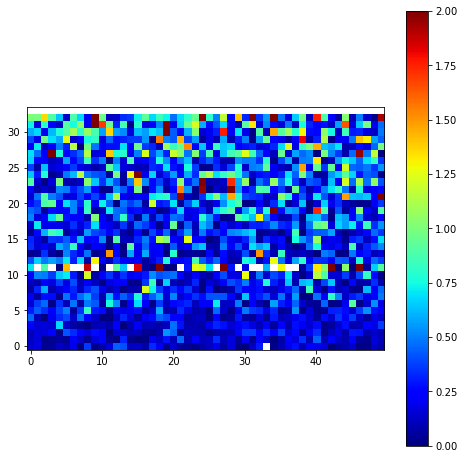

 >> Example 1
 >> Original image:


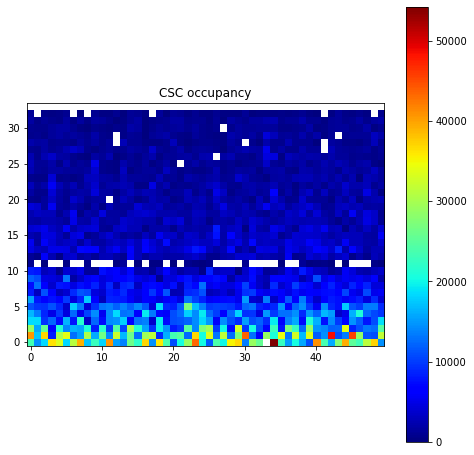

 >> AE-reco image:


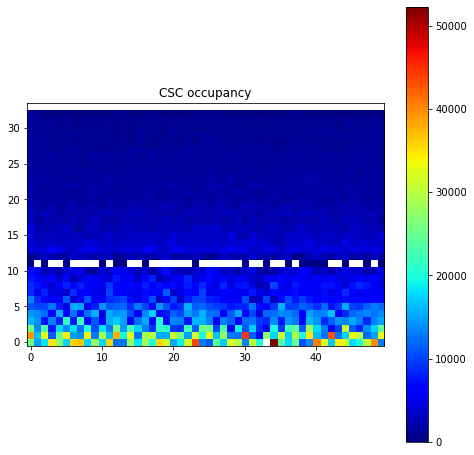

 >> Normalized loss map:


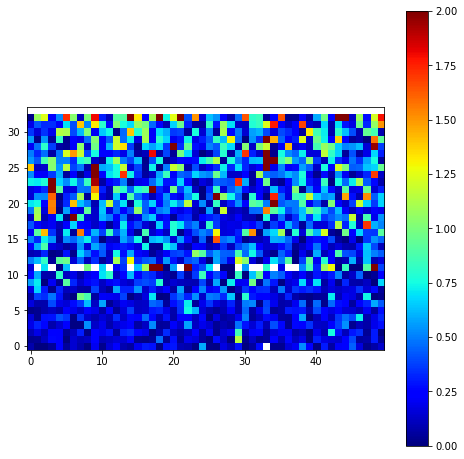

 >> Example 2
 >> Original image:


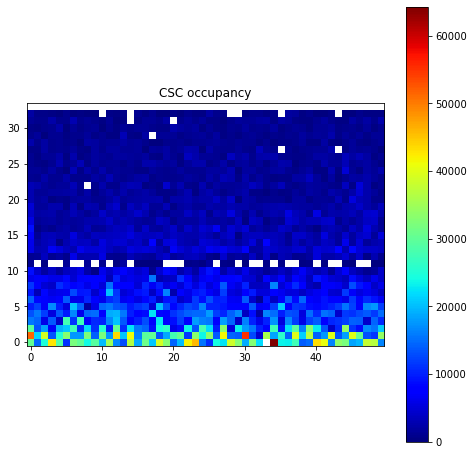

 >> AE-reco image:


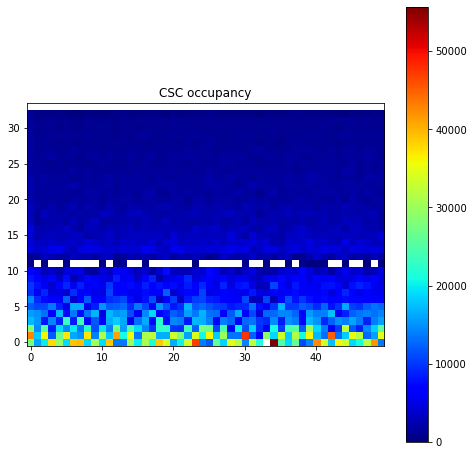

 >> Normalized loss map:


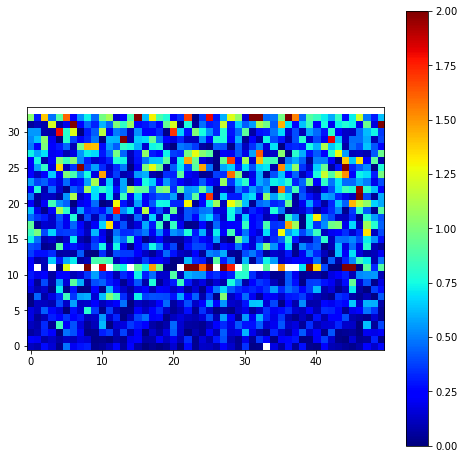

 >> Example 3
 >> Original image:


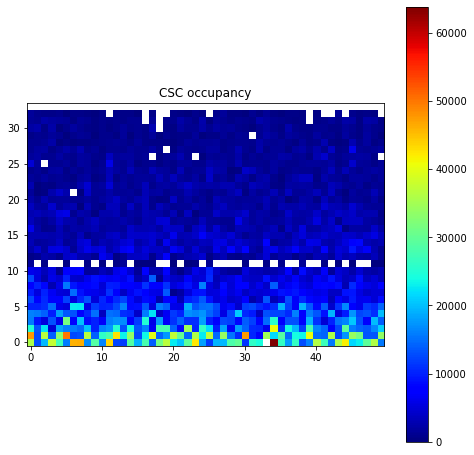

 >> AE-reco image:


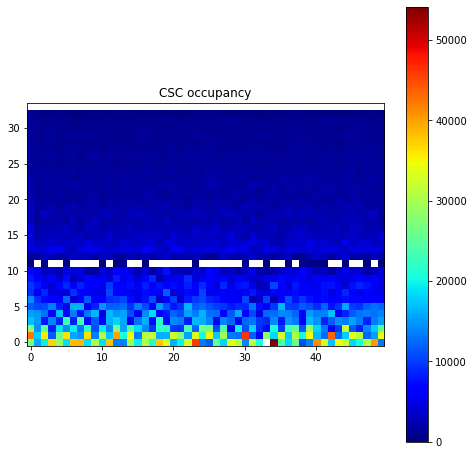

 >> Normalized loss map:


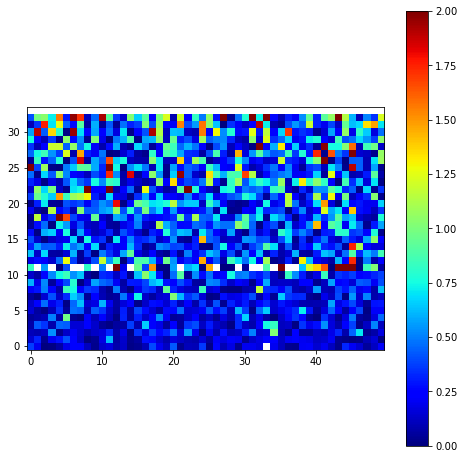

***** batch 3 *****
 >> Example 0
 >> Original image:


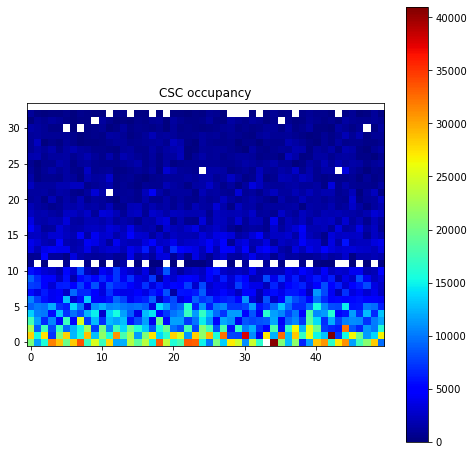

 >> AE-reco image:


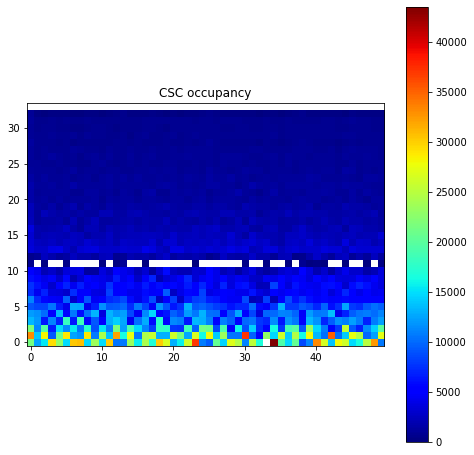

 >> Normalized loss map:


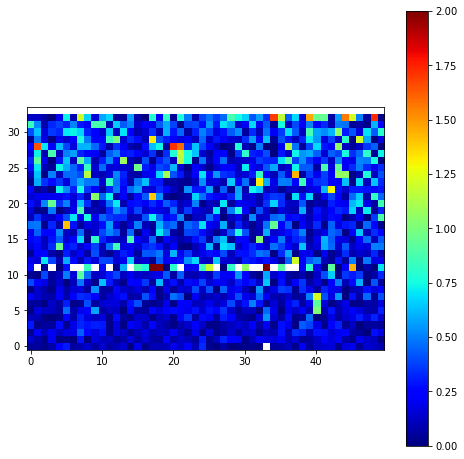

 >> Example 1
 >> Original image:


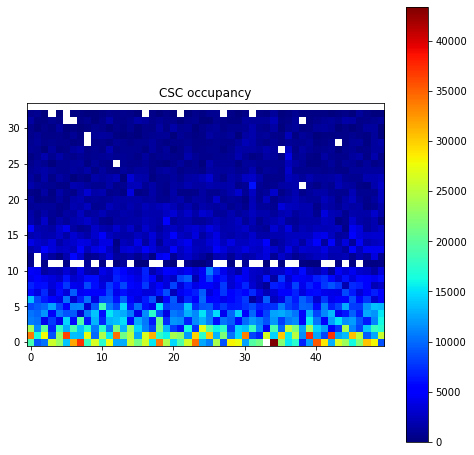

 >> AE-reco image:


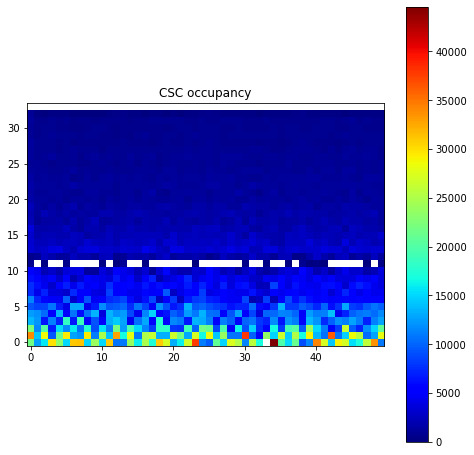

 >> Normalized loss map:


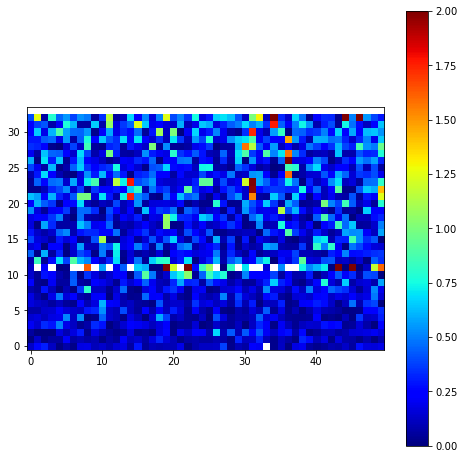

 >> Example 2
 >> Original image:


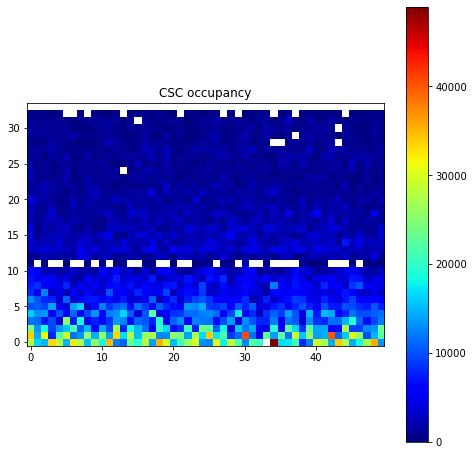

 >> AE-reco image:


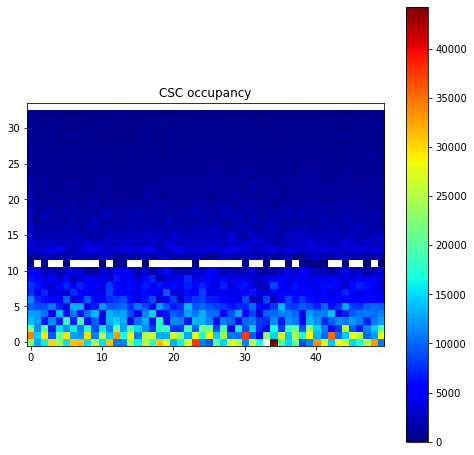

 >> Normalized loss map:


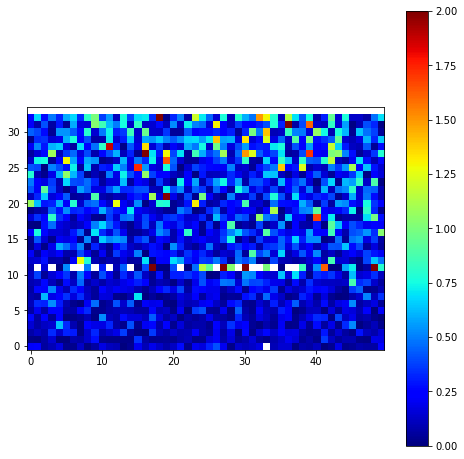

 >> Example 3
 >> Original image:


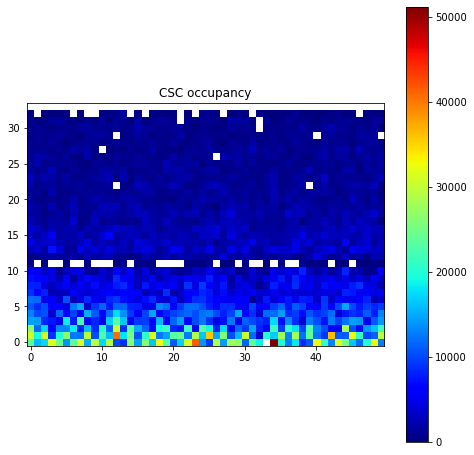

 >> AE-reco image:


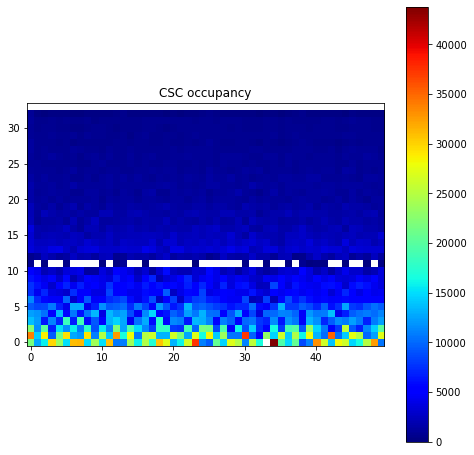

 >> Normalized loss map:


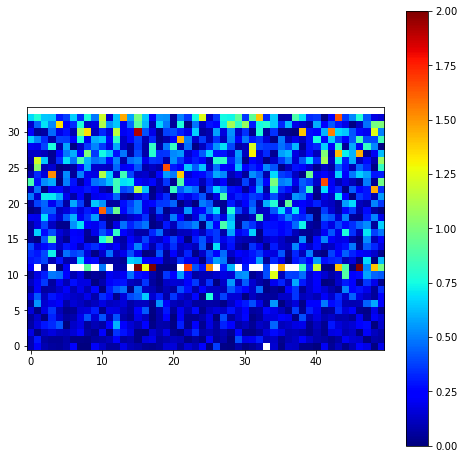

***** batch 4 *****
 >> Example 0
 >> Original image:


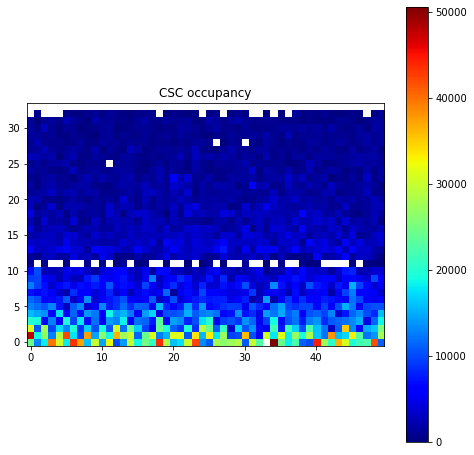

 >> AE-reco image:


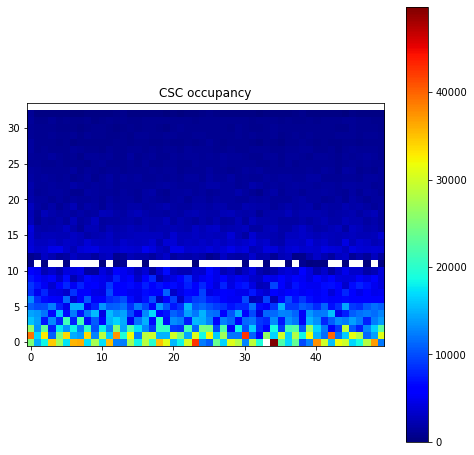

 >> Normalized loss map:


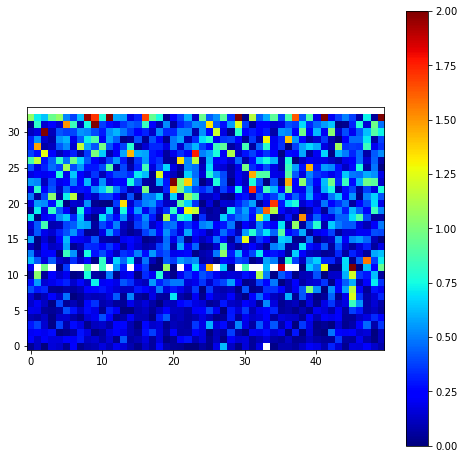

 >> Example 1
 >> Original image:


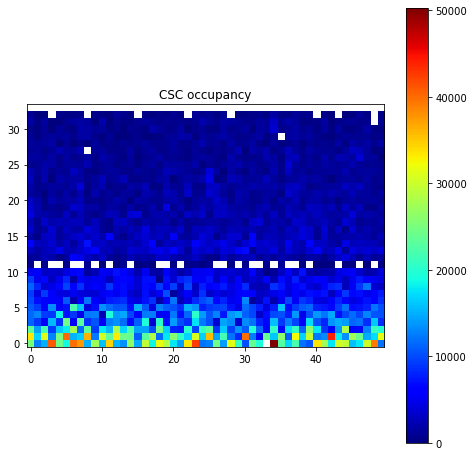

 >> AE-reco image:


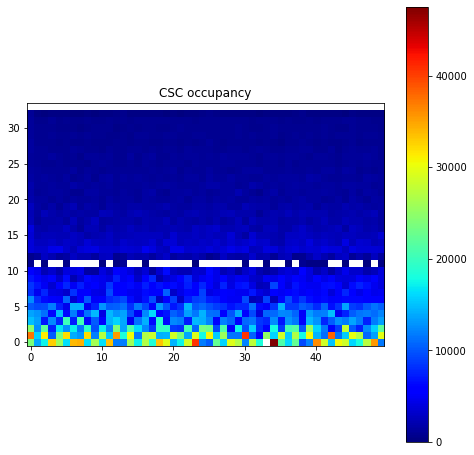

 >> Normalized loss map:


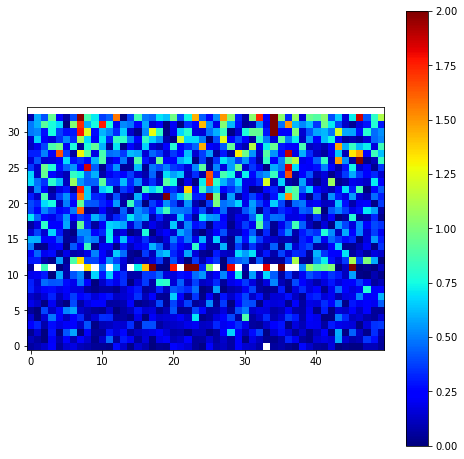

 >> Example 2
 >> Original image:


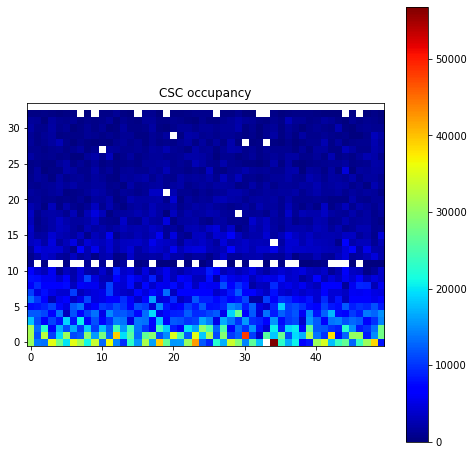

 >> AE-reco image:


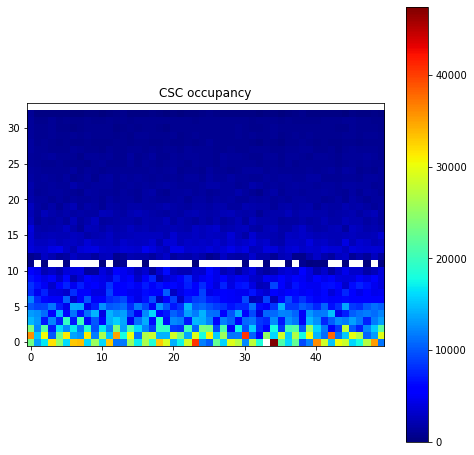

 >> Normalized loss map:


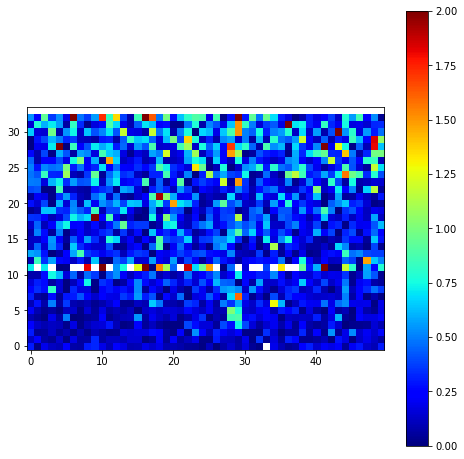

 >> Example 3
 >> Original image:


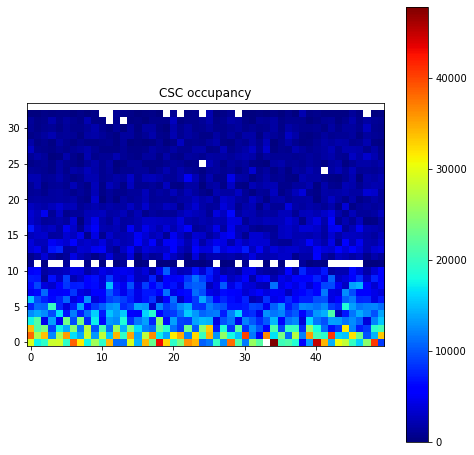

 >> AE-reco image:


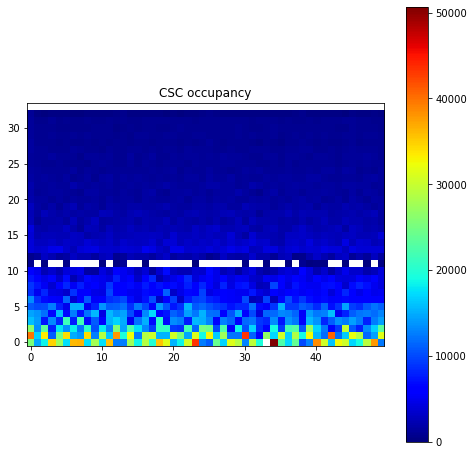

 >> Normalized loss map:


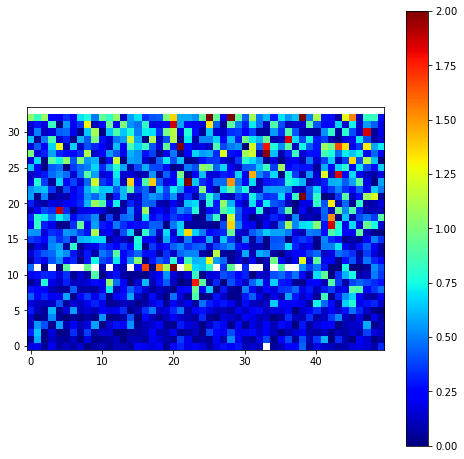

***** batch 5 *****
 >> Example 0
 >> Original image:


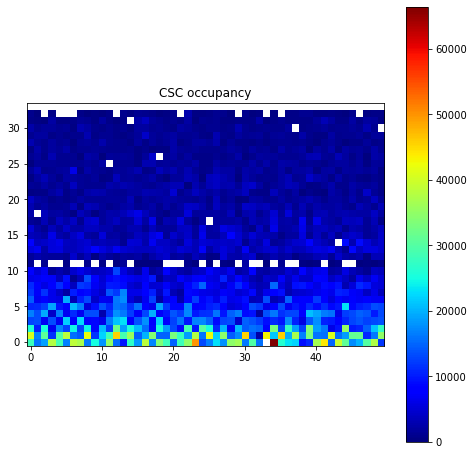

 >> AE-reco image:


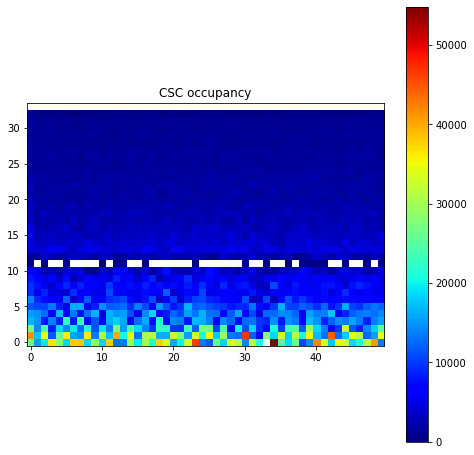

 >> Normalized loss map:


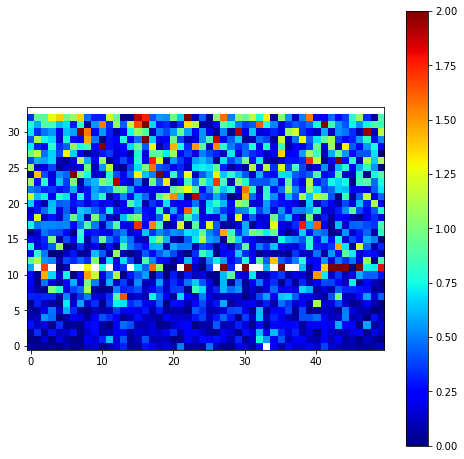

 >> Example 1
 >> Original image:


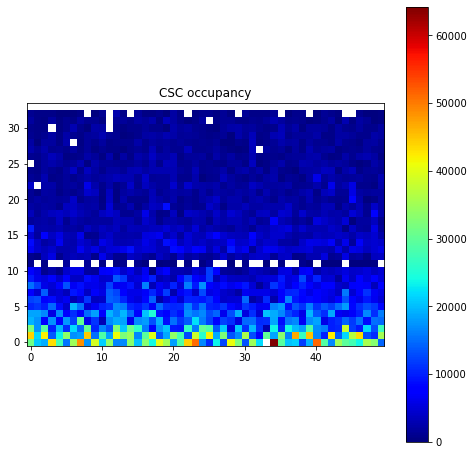

 >> AE-reco image:


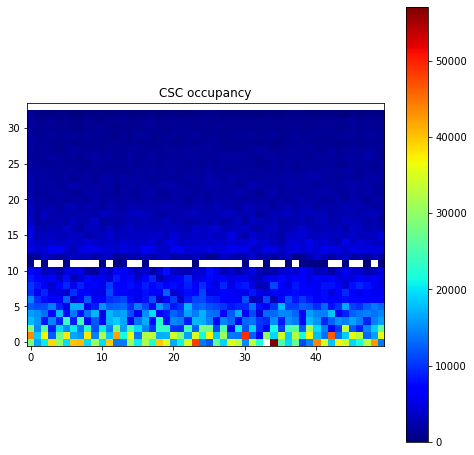

 >> Normalized loss map:


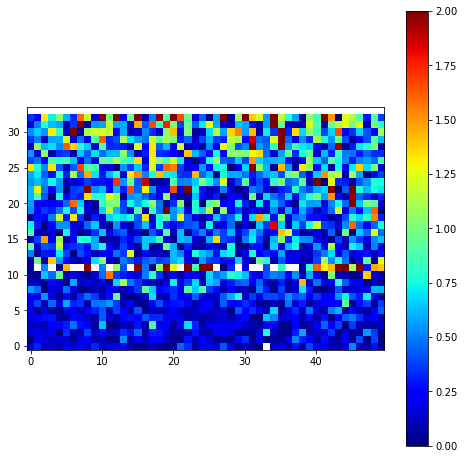

 >> Example 2
 >> Original image:


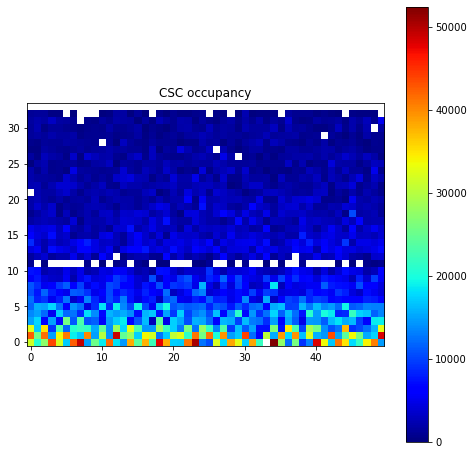

 >> AE-reco image:


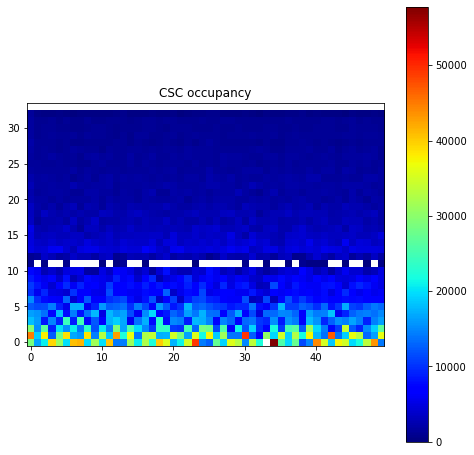

 >> Normalized loss map:


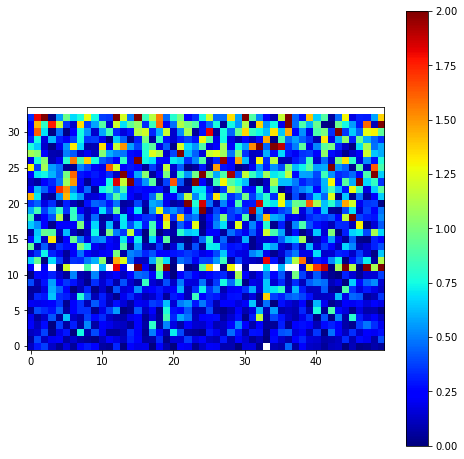

 >> Example 3
 >> Original image:


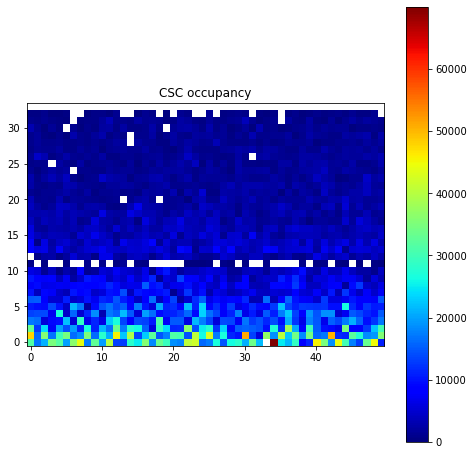

 >> AE-reco image:


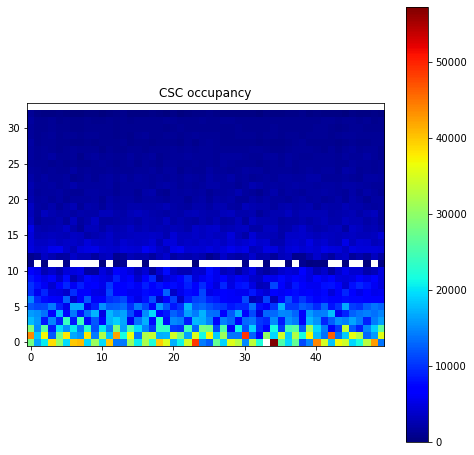

 >> Normalized loss map:


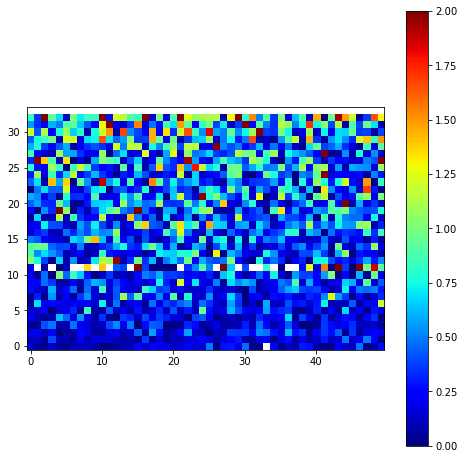

***** batch 6 *****
 >> Example 0
 >> Original image:


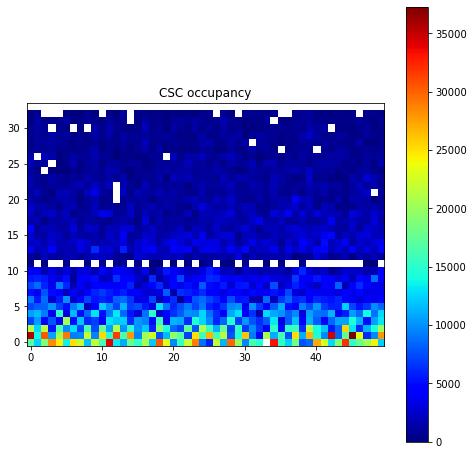

 >> AE-reco image:


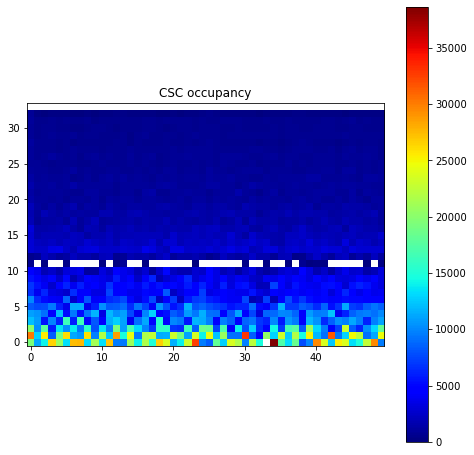

 >> Normalized loss map:


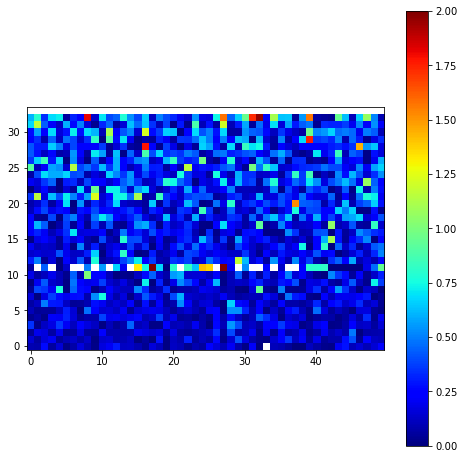

 >> Example 1
 >> Original image:


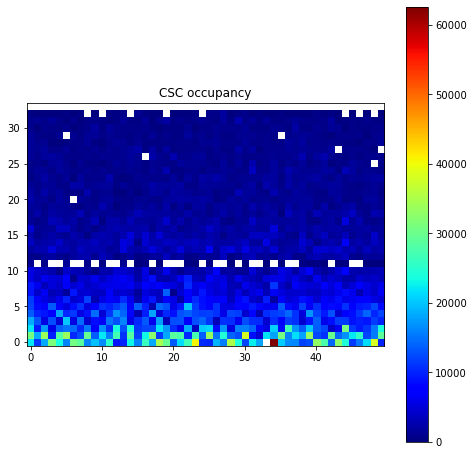

 >> AE-reco image:


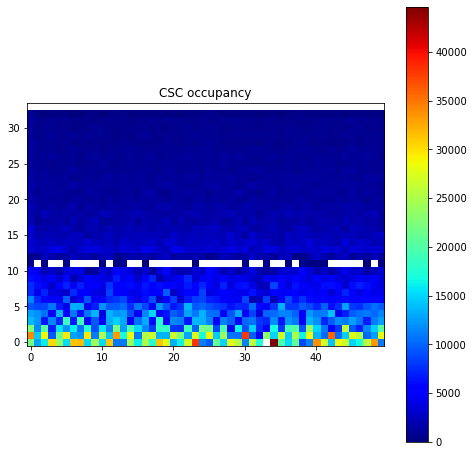

 >> Normalized loss map:


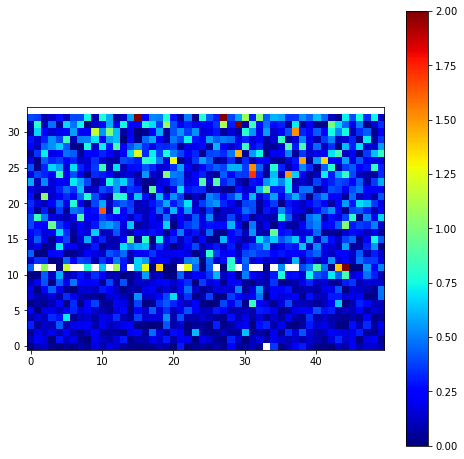

 >> Example 2
 >> Original image:


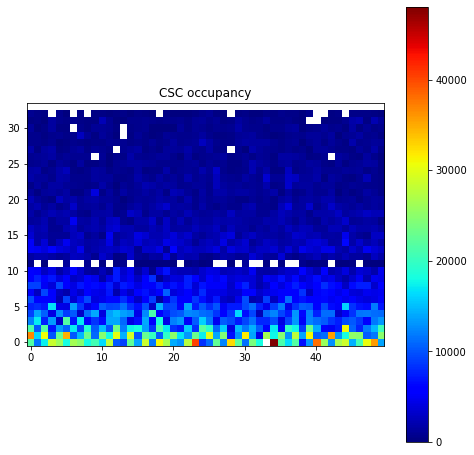

 >> AE-reco image:


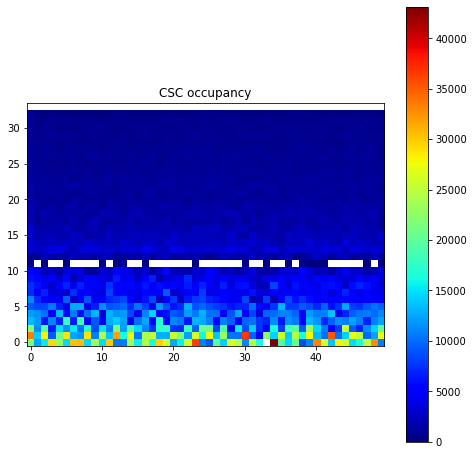

 >> Normalized loss map:


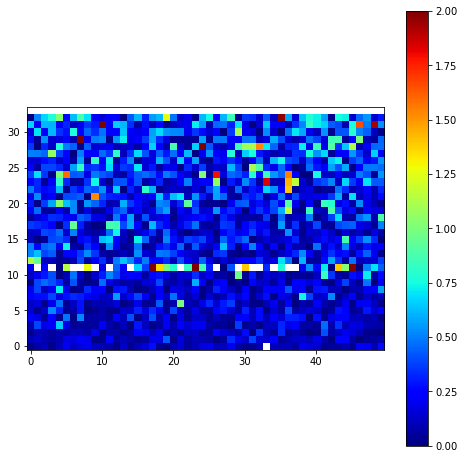

 >> Example 3
 >> Original image:


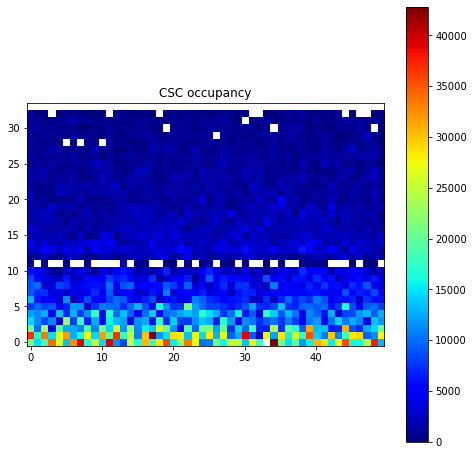

 >> AE-reco image:


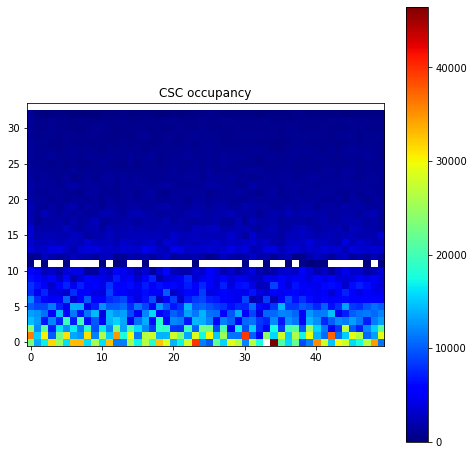

 >> Normalized loss map:


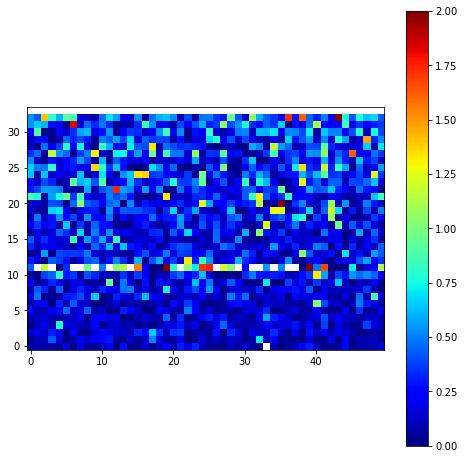

***** batch 7 *****
 >> Example 0
 >> Original image:


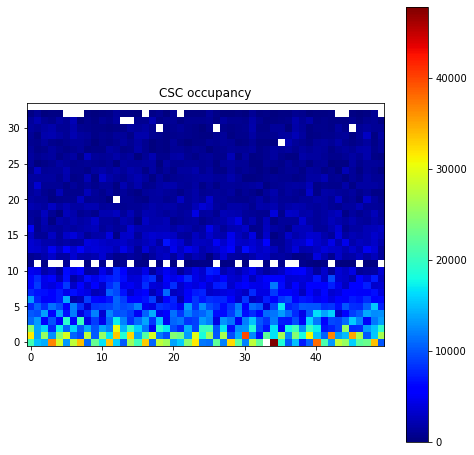

 >> AE-reco image:


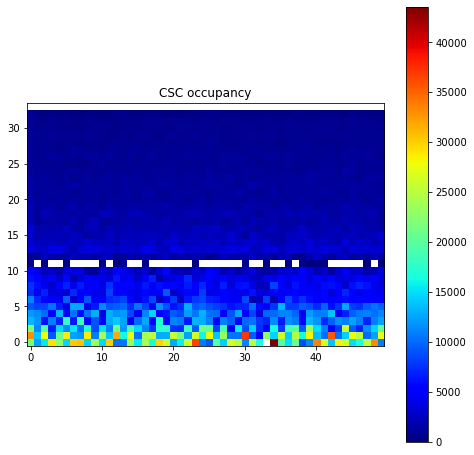

 >> Normalized loss map:


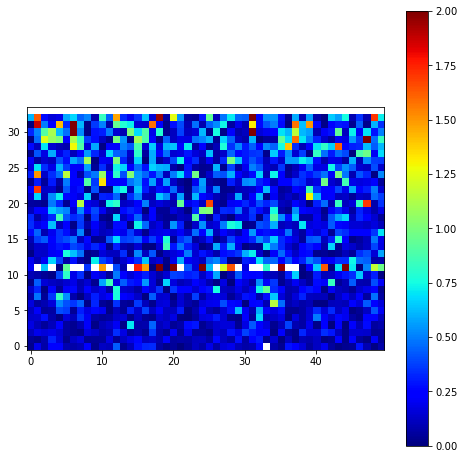

 >> Example 1
 >> Original image:


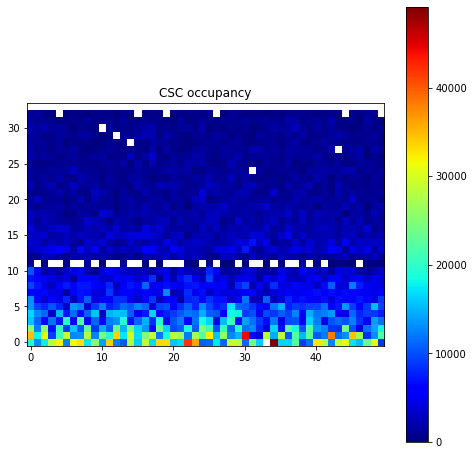

 >> AE-reco image:


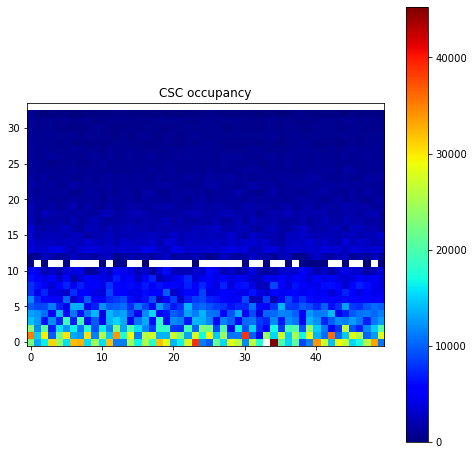

 >> Normalized loss map:


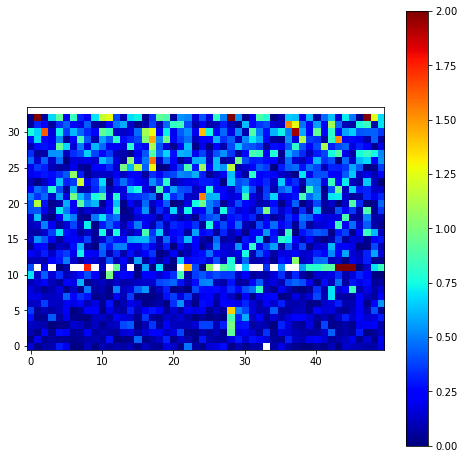

 >> Example 2
 >> Original image:


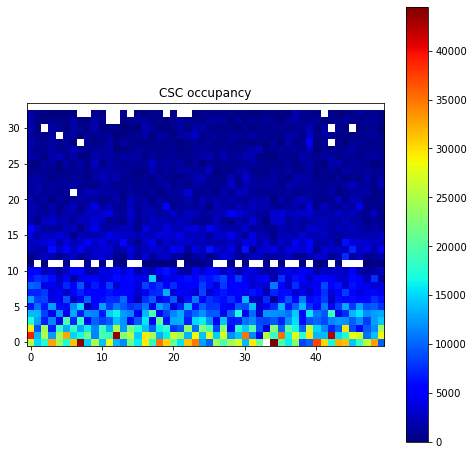

 >> AE-reco image:


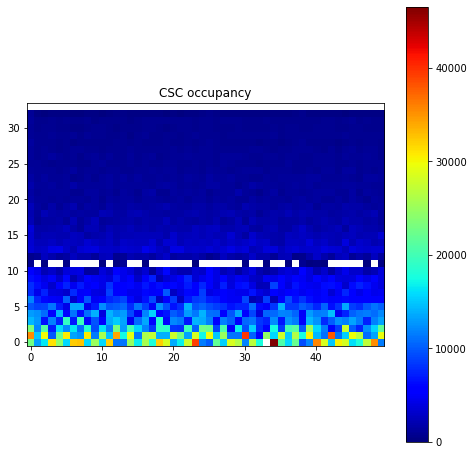

 >> Normalized loss map:


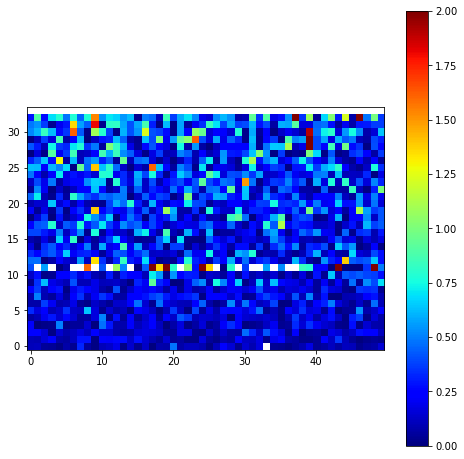

 >> Example 3
 >> Original image:


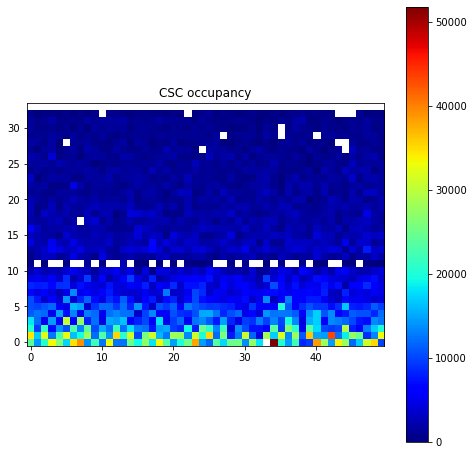

 >> AE-reco image:


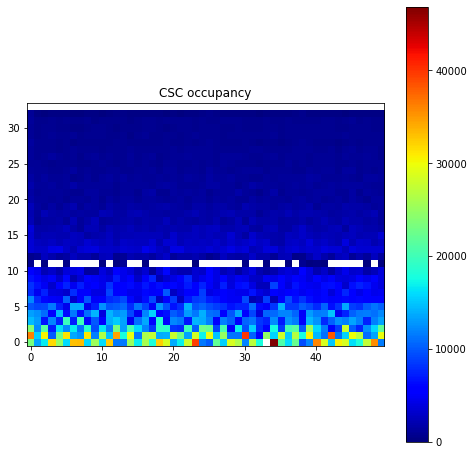

 >> Normalized loss map:


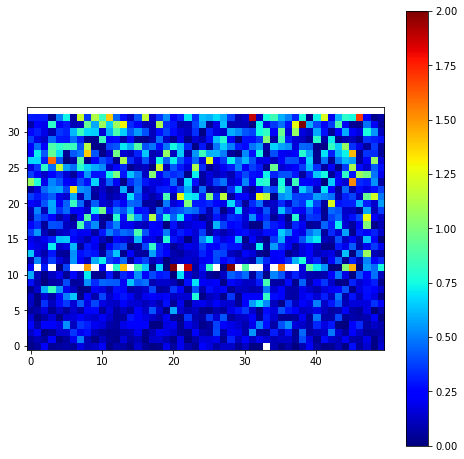

***** batch 8 *****
 >> Example 0
 >> Original image:


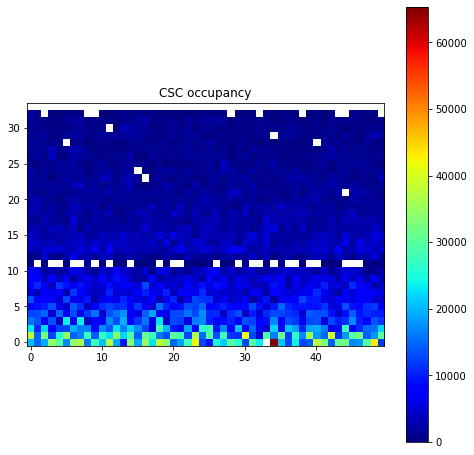

 >> AE-reco image:


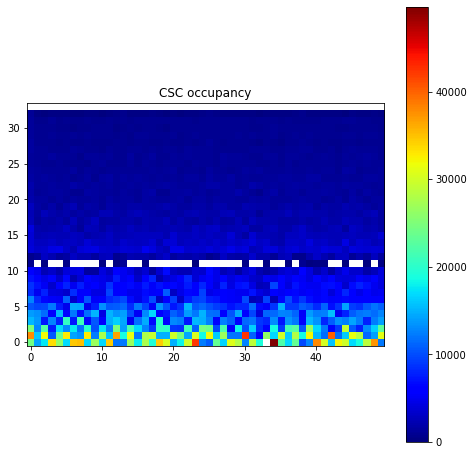

 >> Normalized loss map:


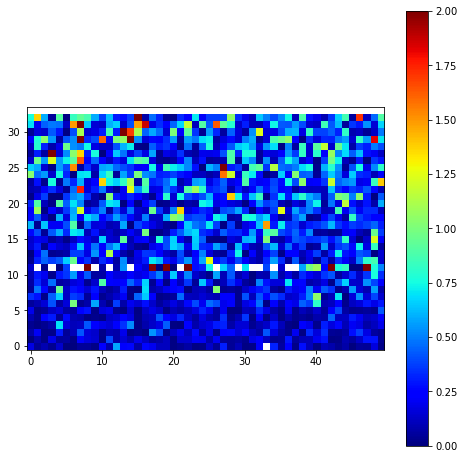

 >> Example 1
 >> Original image:


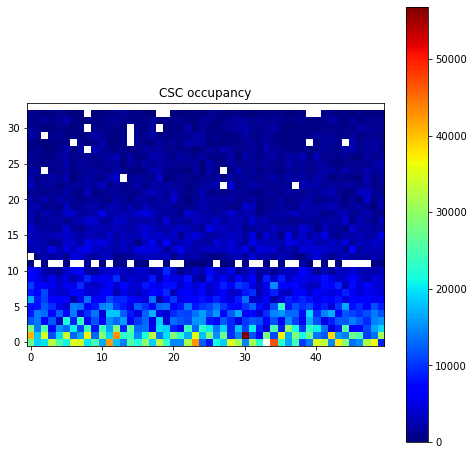

 >> AE-reco image:


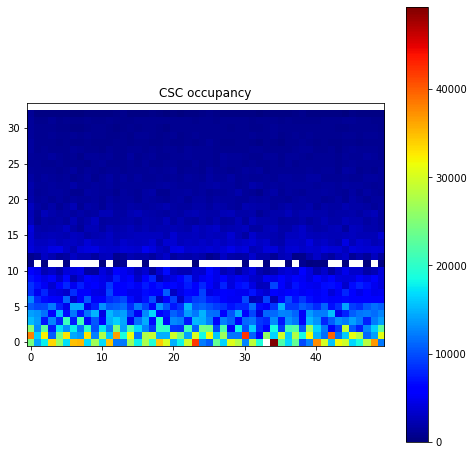

 >> Normalized loss map:


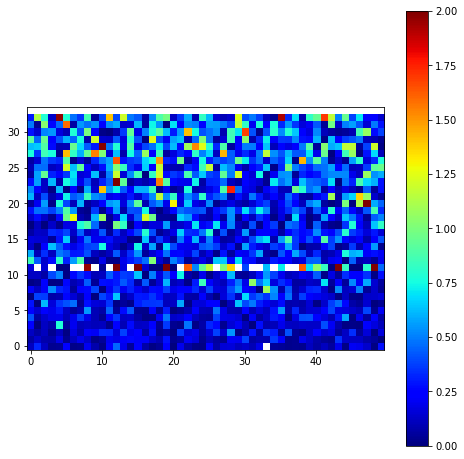

 >> Example 2
 >> Original image:


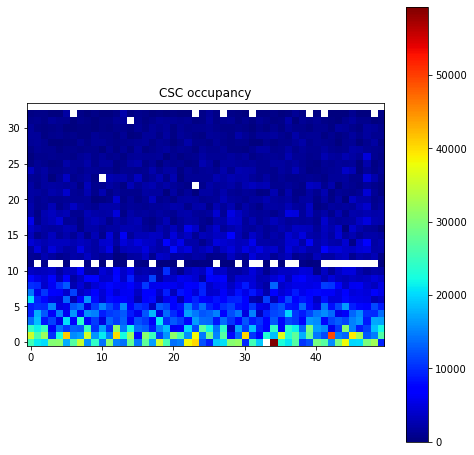

 >> AE-reco image:


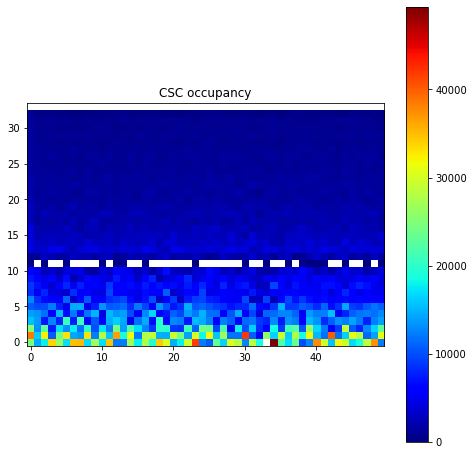

 >> Normalized loss map:


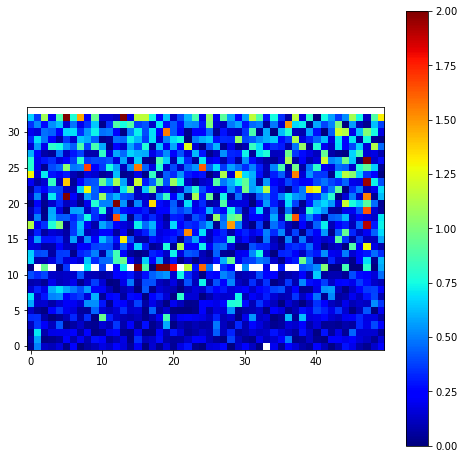

 >> Example 3
 >> Original image:


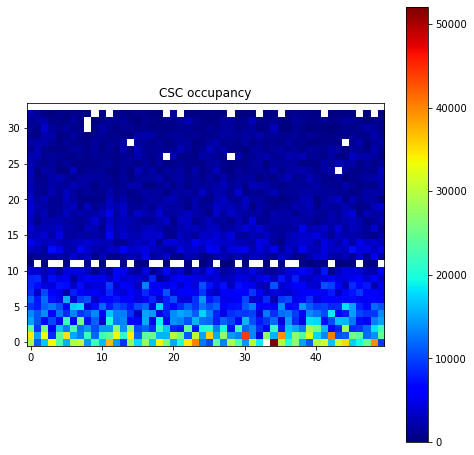

 >> AE-reco image:


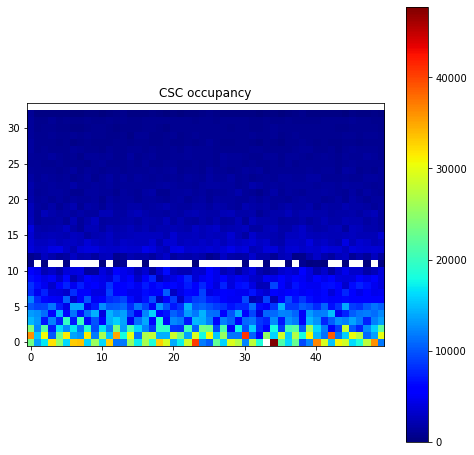

 >> Normalized loss map:


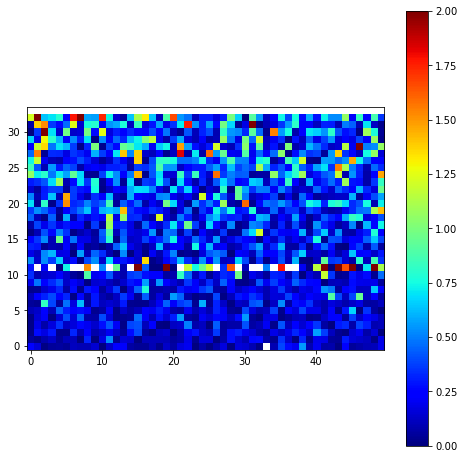

***** batch 9 *****
 >> Example 0
 >> Original image:


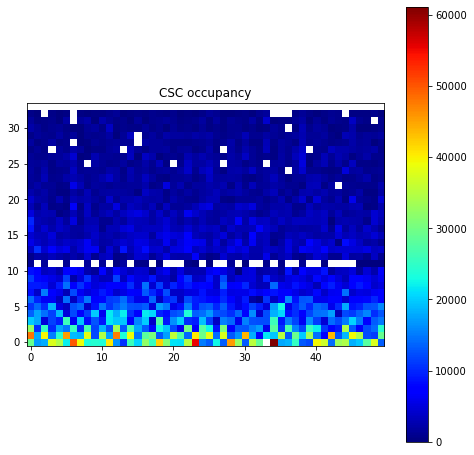

 >> AE-reco image:


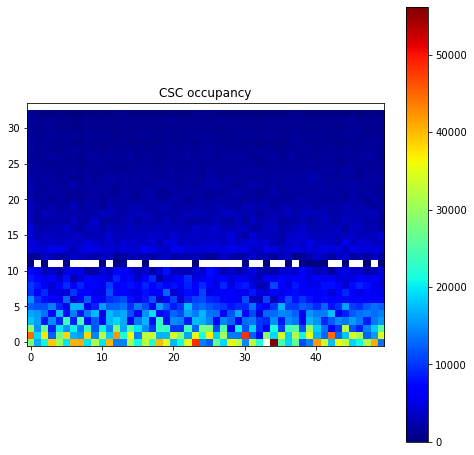

 >> Normalized loss map:


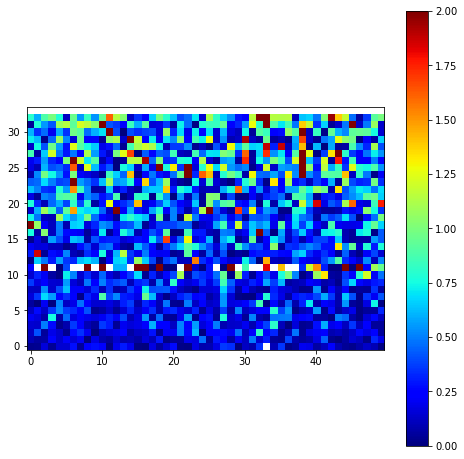

 >> Example 1
 >> Original image:


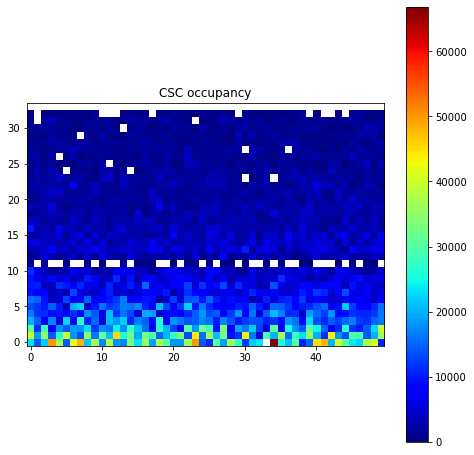

 >> AE-reco image:


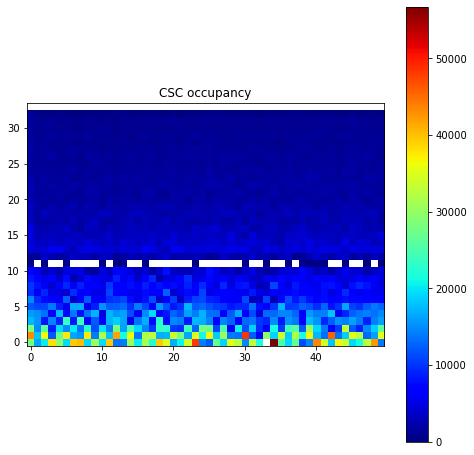

 >> Normalized loss map:


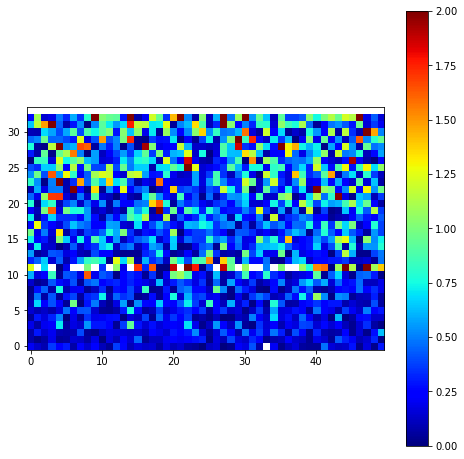

 >> Example 2
 >> Original image:


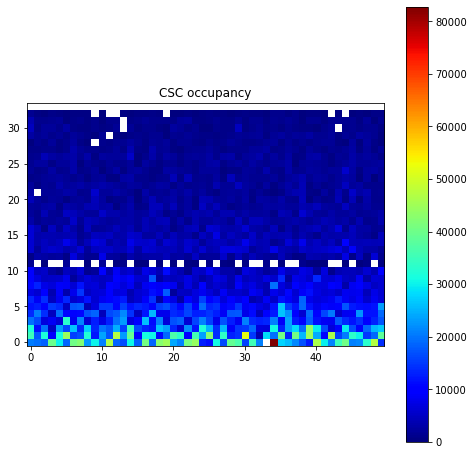

 >> AE-reco image:


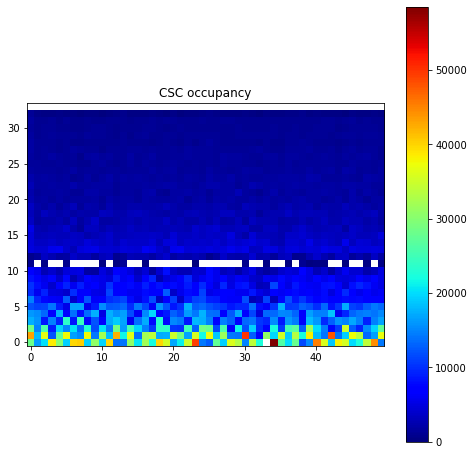

 >> Normalized loss map:


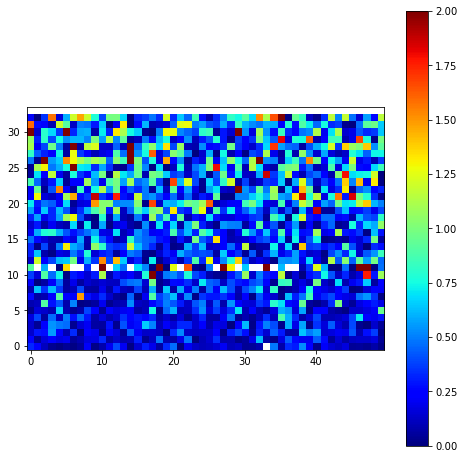

 >> Example 3
 >> Original image:


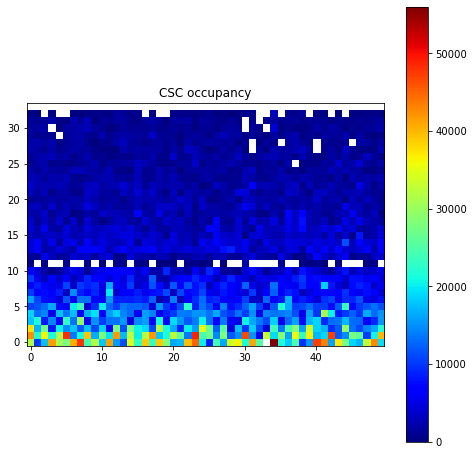

 >> AE-reco image:


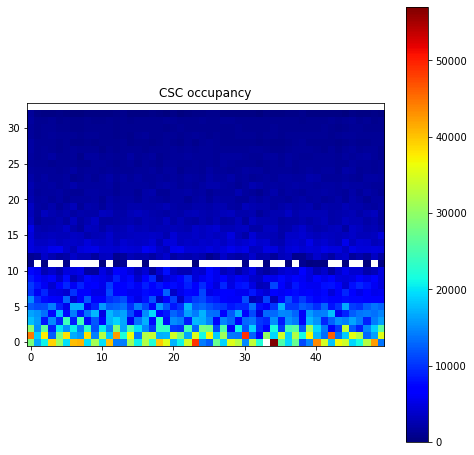

 >> Normalized loss map:


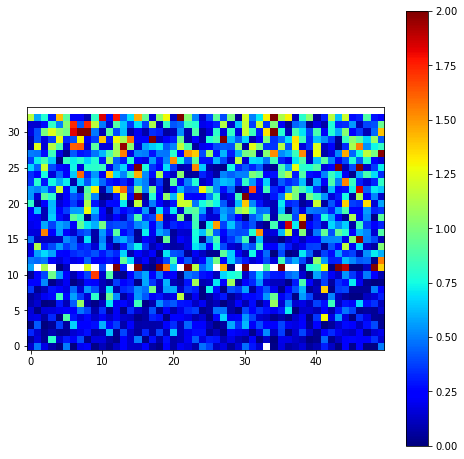

***** batch 10 *****
 >> Example 0
 >> Original image:


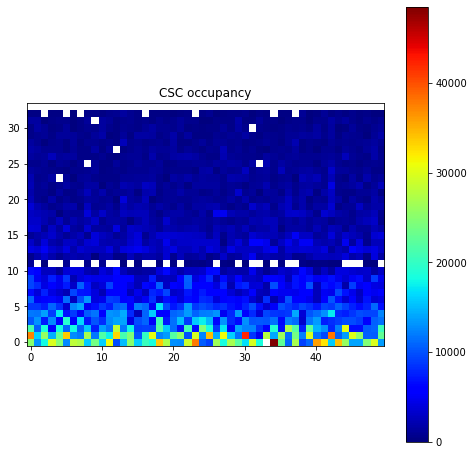

 >> AE-reco image:


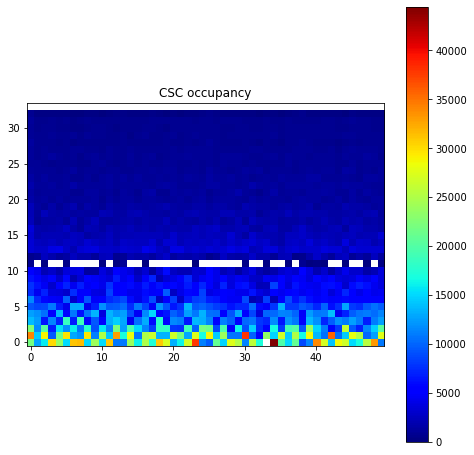

 >> Normalized loss map:


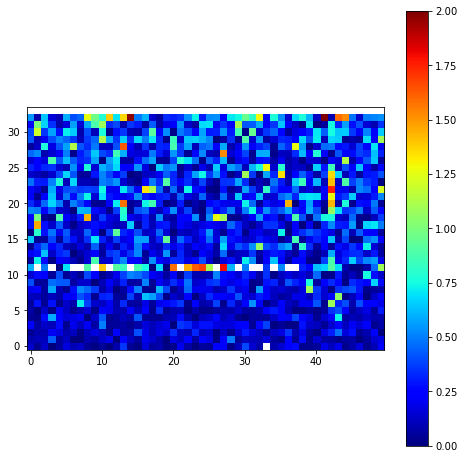

 >> Example 1
 >> Original image:


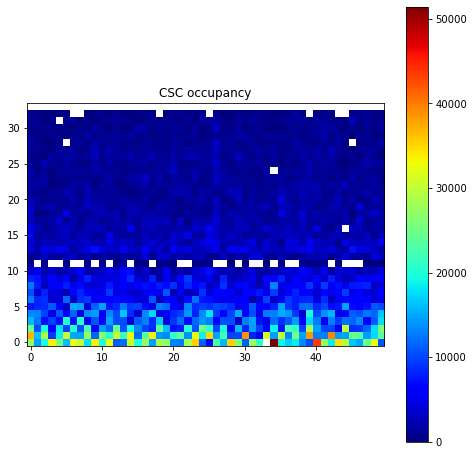

 >> AE-reco image:


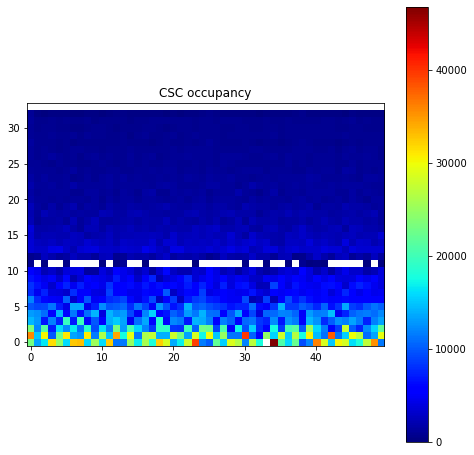

 >> Normalized loss map:


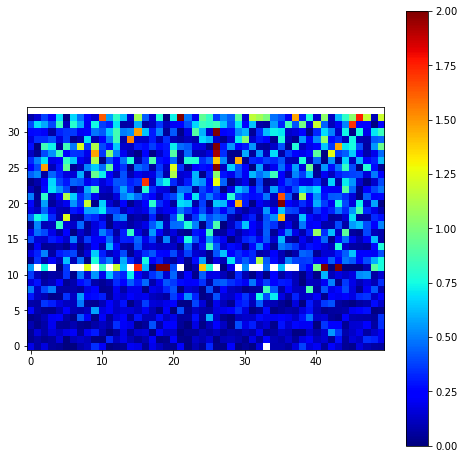

 >> Example 2
 >> Original image:


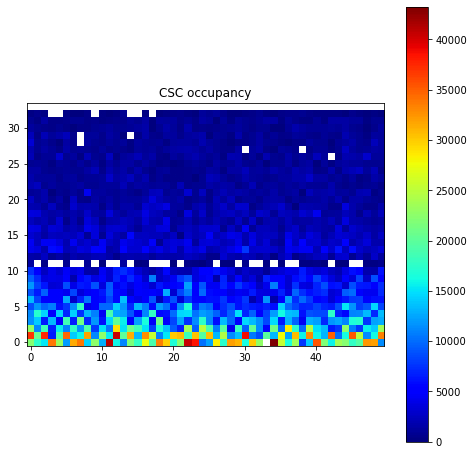

 >> AE-reco image:


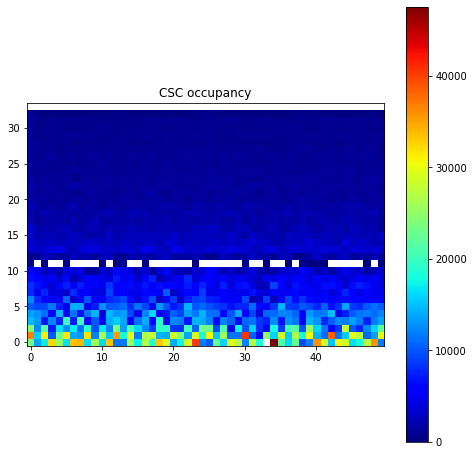

 >> Normalized loss map:


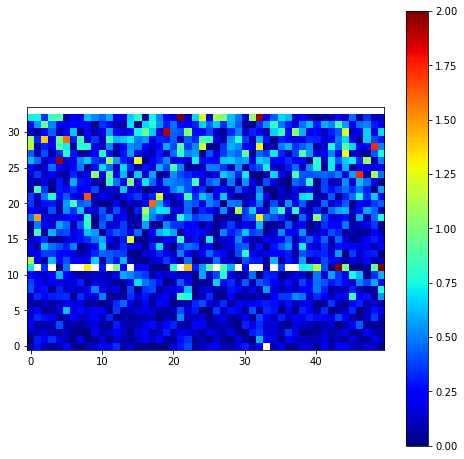

 >> Example 3
 >> Original image:


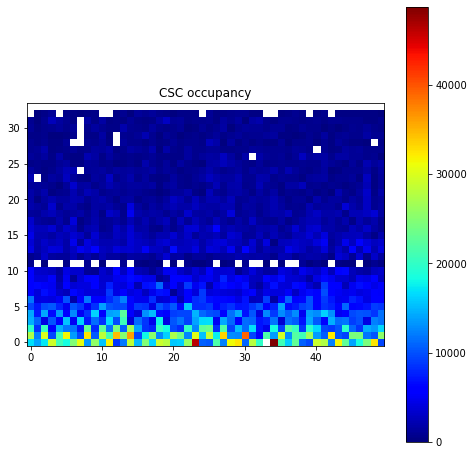

 >> AE-reco image:


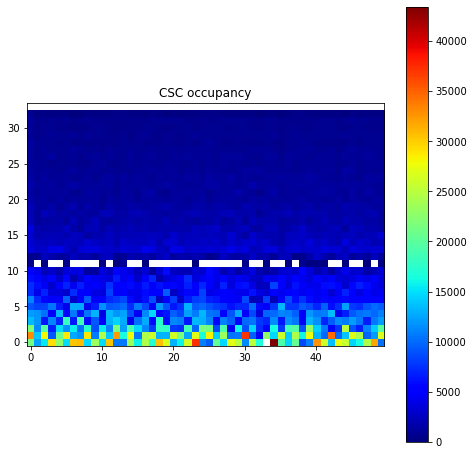

 >> Normalized loss map:


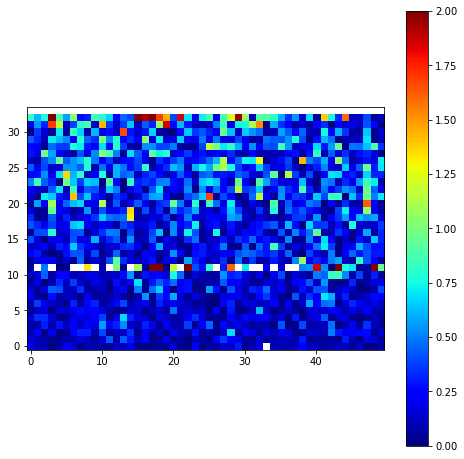

***** batch 11 *****
 >> Example 0
 >> Original image:


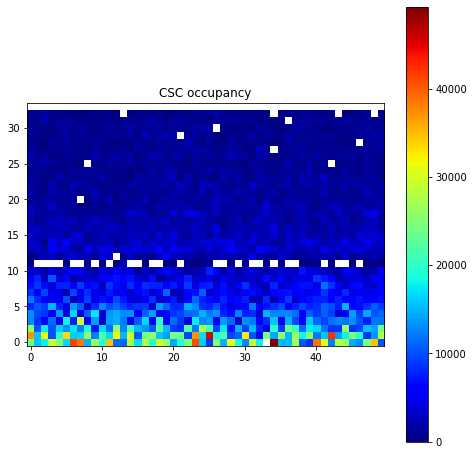

 >> AE-reco image:


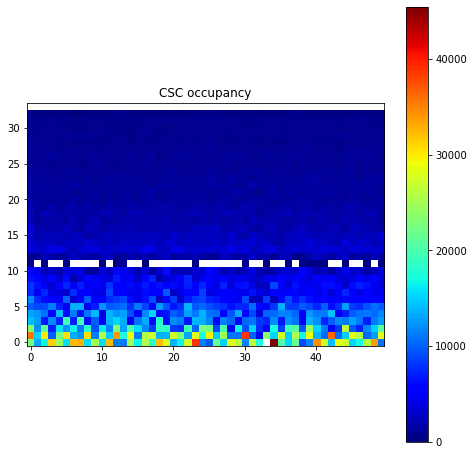

 >> Normalized loss map:


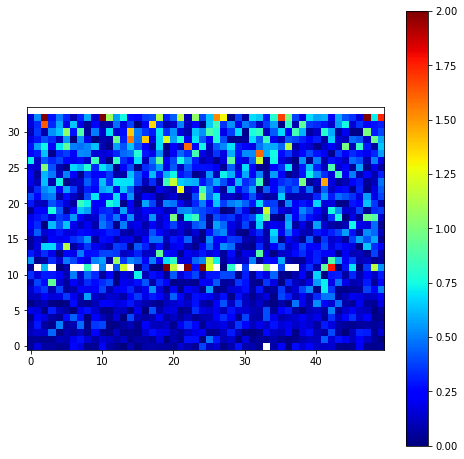

 >> Example 1
 >> Original image:


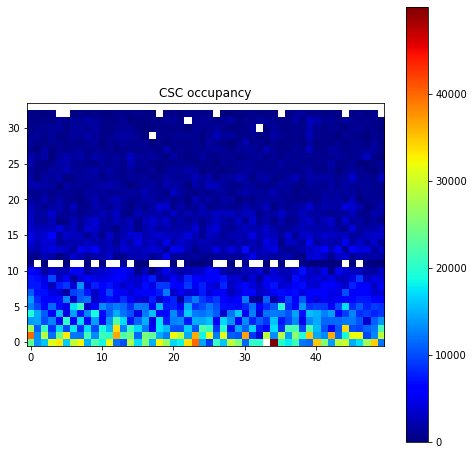

 >> AE-reco image:


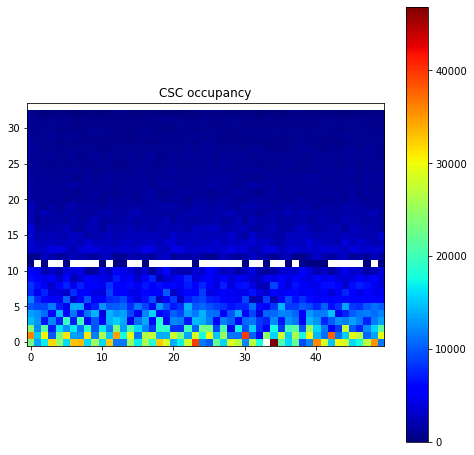

 >> Normalized loss map:


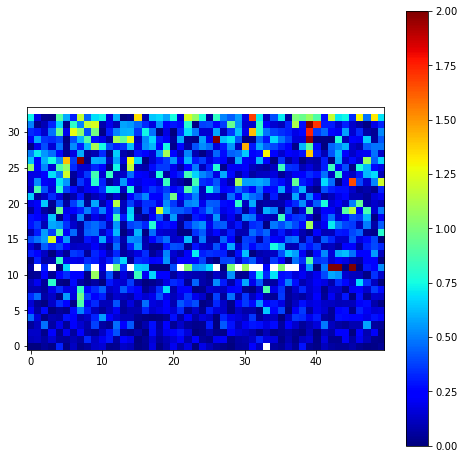

 >> Example 2
 >> Original image:


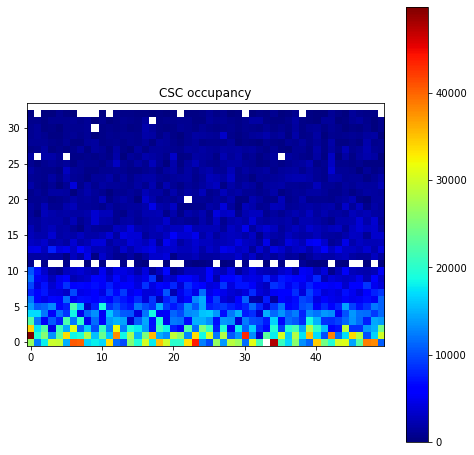

 >> AE-reco image:


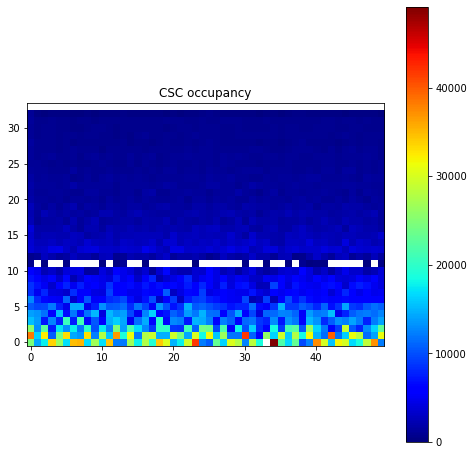

 >> Normalized loss map:


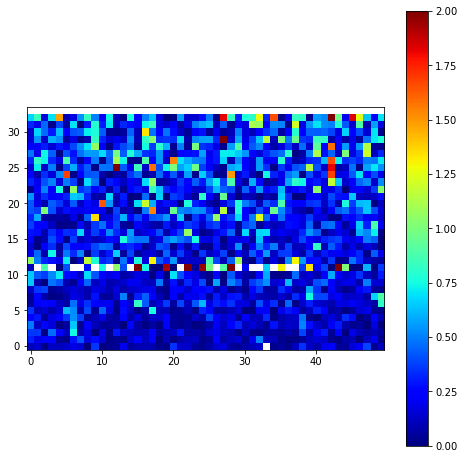

 >> Example 3
 >> Original image:


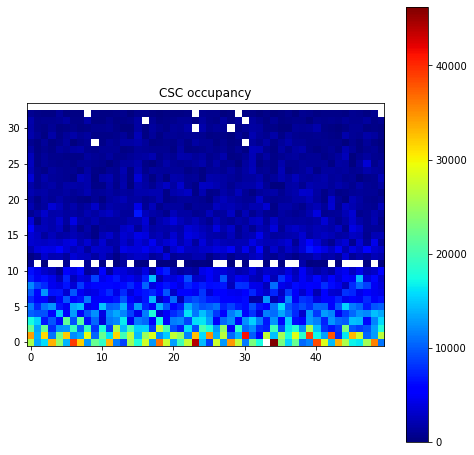

 >> AE-reco image:


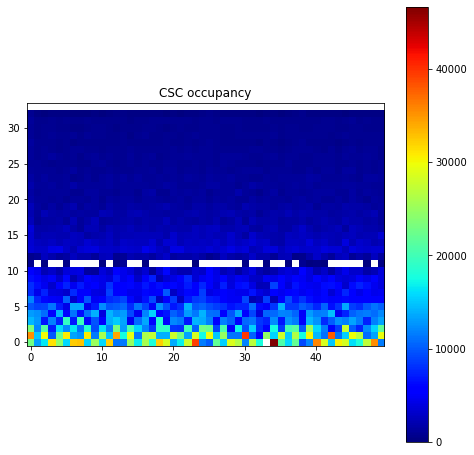

 >> Normalized loss map:


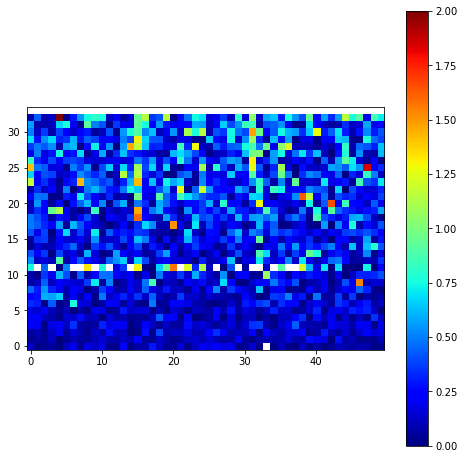

***** batch 12 *****
 >> Example 0
 >> Original image:


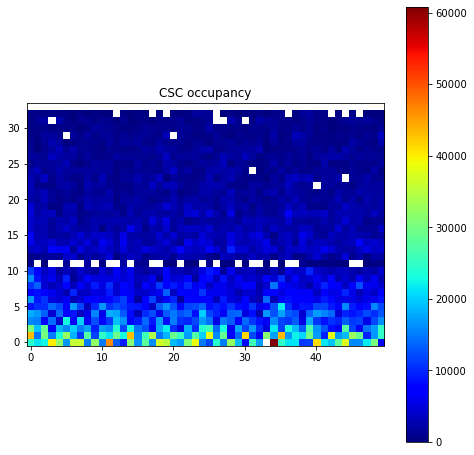

 >> AE-reco image:


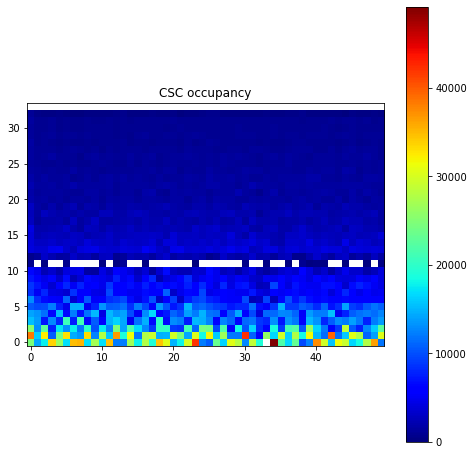

 >> Normalized loss map:


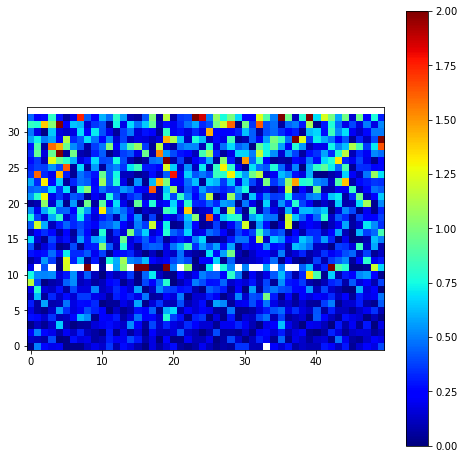

 >> Example 1
 >> Original image:


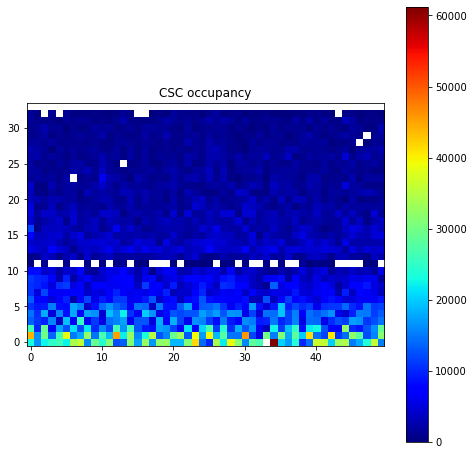

 >> AE-reco image:


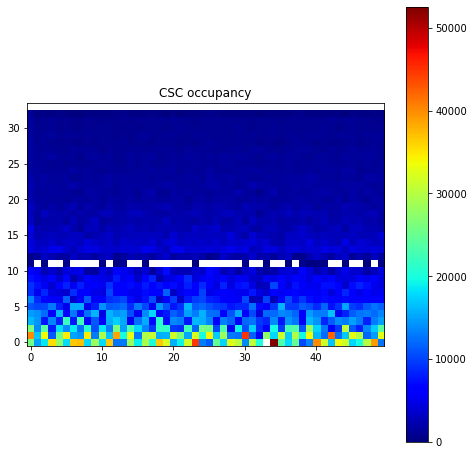

 >> Normalized loss map:


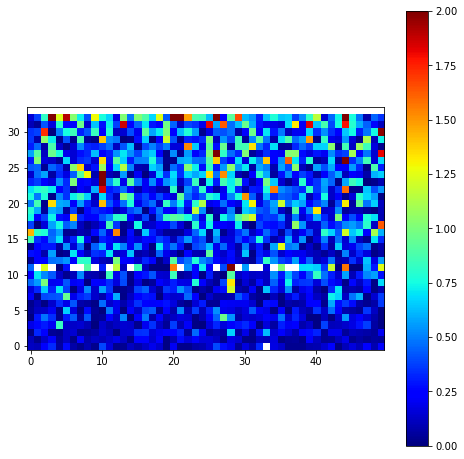

 >> Example 2
 >> Original image:


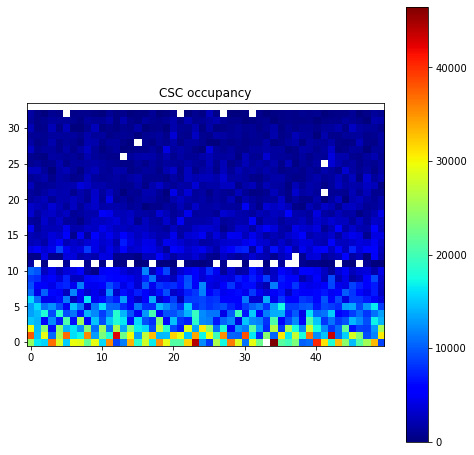

 >> AE-reco image:


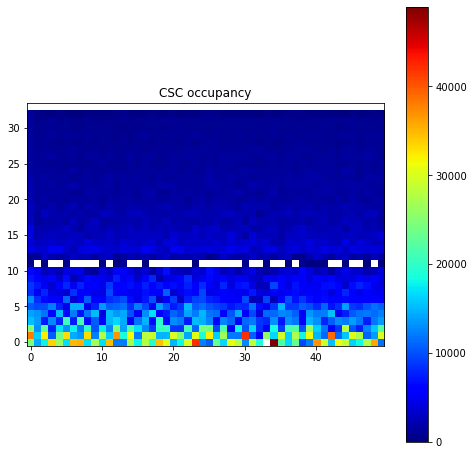

 >> Normalized loss map:


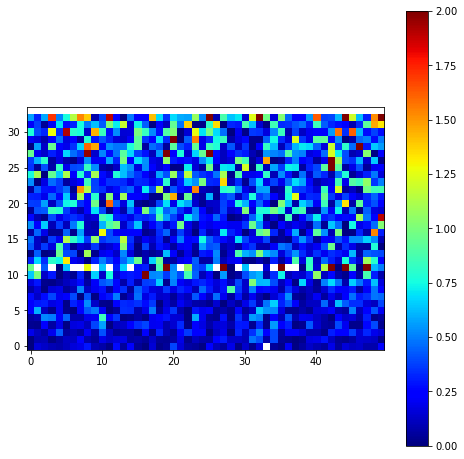

 >> Example 3
 >> Original image:


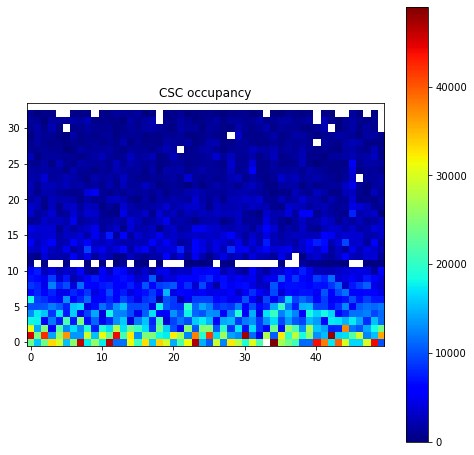

 >> AE-reco image:


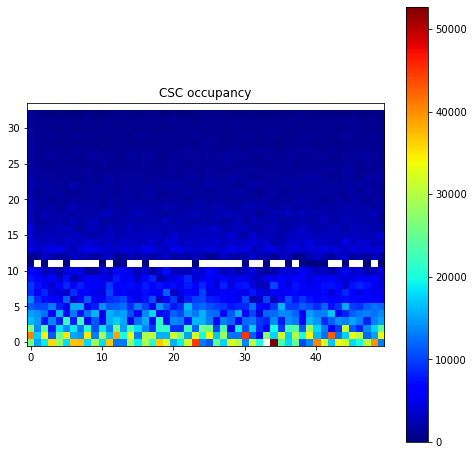

 >> Normalized loss map:


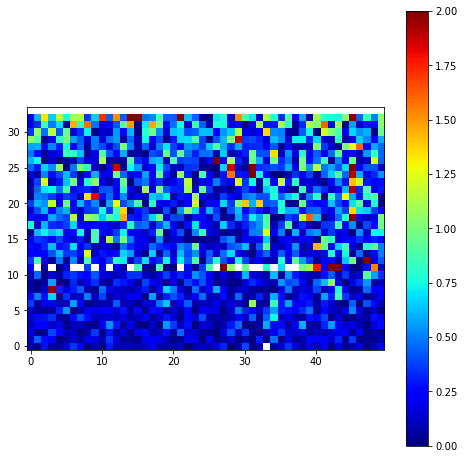

***** batch 13 *****
 >> Example 0
 >> Original image:


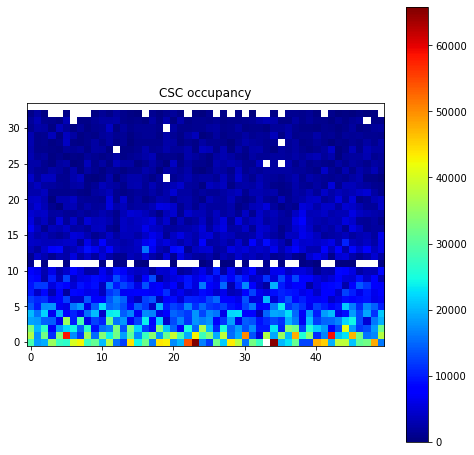

 >> AE-reco image:


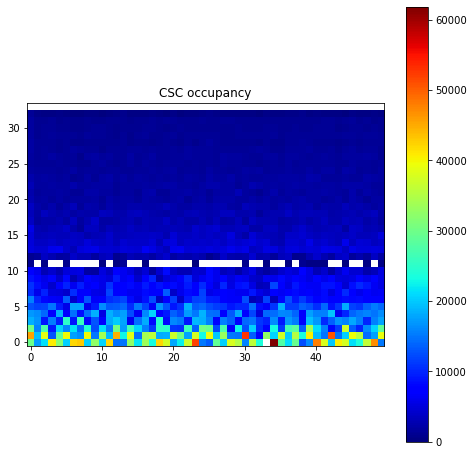

 >> Normalized loss map:


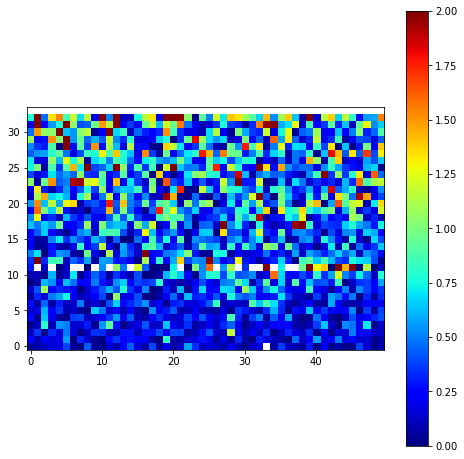

 >> Example 1
 >> Original image:


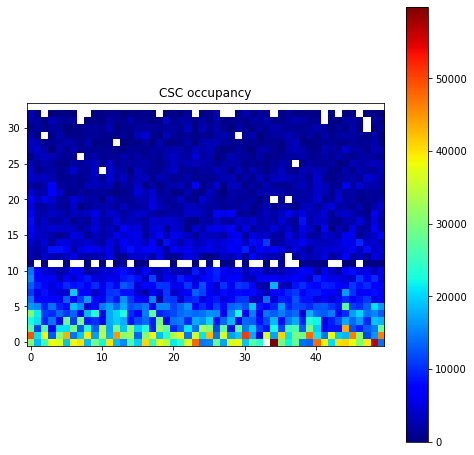

 >> AE-reco image:


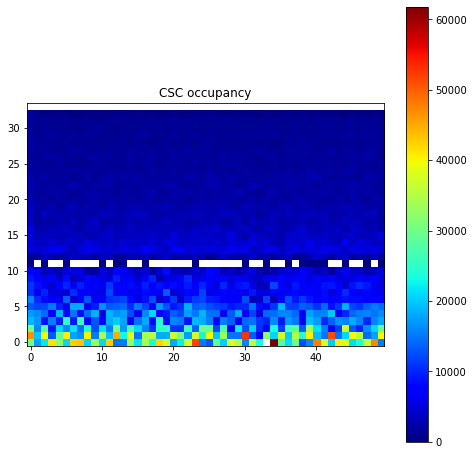

 >> Normalized loss map:


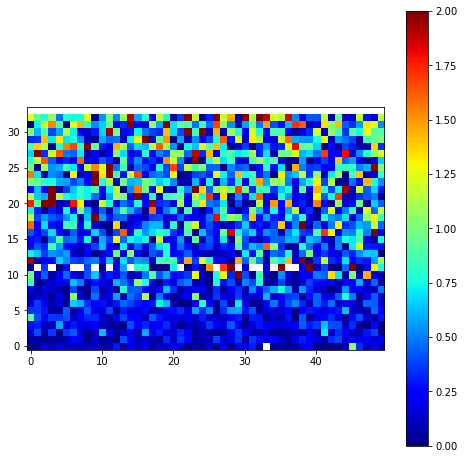

 >> Example 2
 >> Original image:


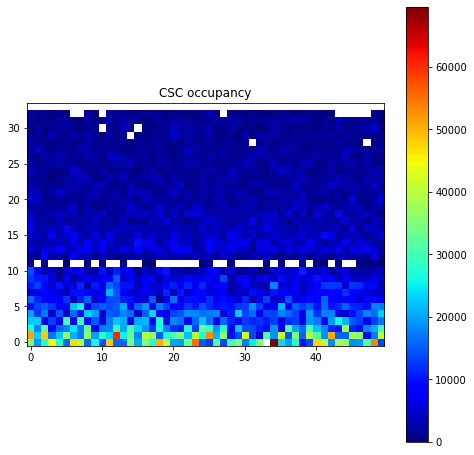

 >> AE-reco image:


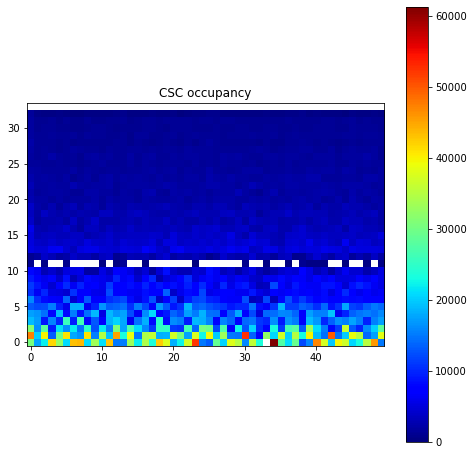

 >> Normalized loss map:


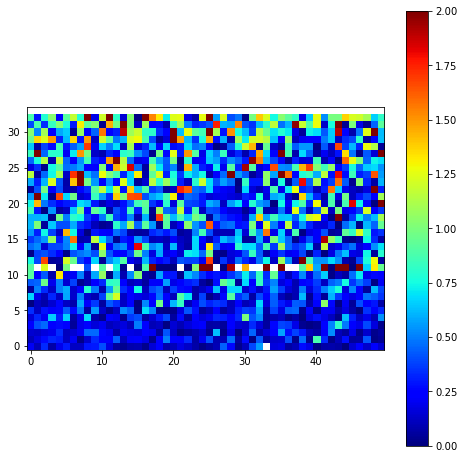

 >> Example 3
 >> Original image:


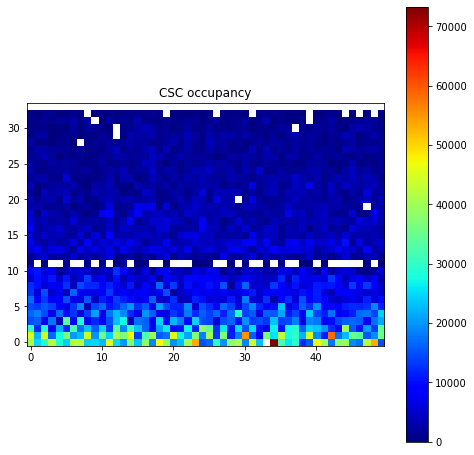

 >> AE-reco image:


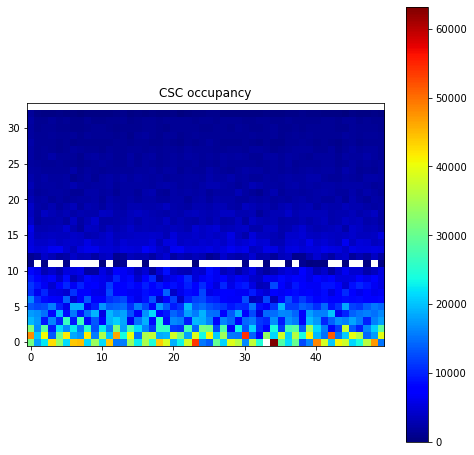

 >> Normalized loss map:


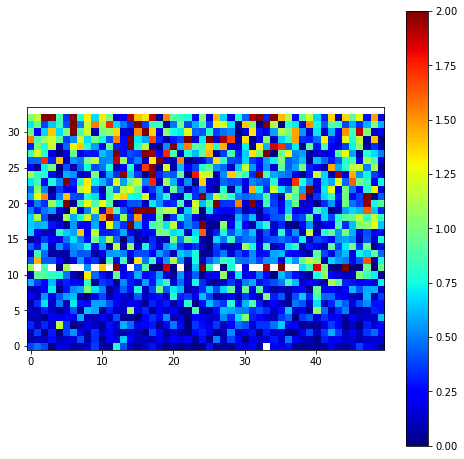

In [40]:
for i, img in enumerate(validation_loader):
    img = img.to(device)
    #img = img*(img<10).float()
    reco_img = ae(img)
    print(f"***** batch {i} *****")
    #k=0
    #if True:
    for k in range(4):
        print(f" >> Example {k}")
        print(' >> Original image:')
        Show2Dimg(img[k][0].cpu().numpy())
        print(' >> AE-reco image:')
        Show2Dimg(reco_img[k][0].detach().cpu().numpy())
        print(' >> Normalized loss map:')
        img_loss = F.l1_loss(reco_img[k], img[k], reduction='none')[0].detach().cpu().numpy()
        #Show2Dimg(img_loss/mean_matrix)
        out = img_loss/mean_matrix
        fig = plt.figure(figsize =(8, 8))
        plt.imshow(out, cmap=plt.cm.jet, vmin=0, vmax=2)
        plt.gca().invert_yaxis()
        plt.colorbar()
        plt.show()